In [3]:
# Adikteev case study

# imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import datetime as dt
import seaborn as sns
sns.set(color_codes=True)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
from pprint import pprint
import time

In [4]:
from platform import python_version
print(python_version())
print(pd.__version__)
print(np.__version__)

3.7.1
0.23.4
1.15.4


Python pathlib tutorial
http://zetcode.com/python/pathlib/

In [10]:
# Utility functions                   
# create dir for temporal dumped tables
top_dir = "./Adikteev_ex_2/"
tmp_data_dir = "./tmp_data/"
tmp_fig_dir = "./tmp_fig/"
Path(tmp_data_dir).mkdir(parents=True, exist_ok=True)  # ????
Path(tmp_fig_dir).mkdir(parents=True, exist_ok=True)


def read_data(path):
    if path.endswith('.csv'):
        # Avoid "Unnamed" column in dataframe object
        data = pd.read_csv(path, index_col=0)
    else:
        data = pd.read_csv(path)
    print(path)
    return data


def show_table(df):
    print(df.info())
    for c in df.columns:
        print(f"\ncol={c}")
        print(df[c].value_counts(dropna=False))


def nrows(df):
    return len(df.index)


# Filter dataframe rows, with column's value within the given value_list
def df_isin(df, col, value_list):
    return df[df[col].isin(value_list)]


# Filter dataframe rows, with column's value not in the value_list
def df_not_in(df, col, value_list):
    return df[~df[col].isin(value_list)]


def dbg_exit():      # ???
    sys.exit(0)


def dump_data(df, name):          # 输出temp data , 在temp 文件里
    df.to_csv(tmp_data_dir + name)


# Compare two lists and check 
def list_diff(la, lb):
    print("la: ", len(la), "lb: ", len(lb))
    print("la-lb (items in first list only): ", len(set(la) - set(lb)))
    print("lb-la (items in second list only): ", len(set(lb) - set(la)))
    print("la&lb (items in both first and second lists): ", len(set(la) & set(lb)))
    print()

In [11]:
# load data
# Make sure top_dir points to the correct directory
all_purchase = read_data(top_dir + "all_purchase")
marketed_custom_actions = read_data(top_dir + "marketed_custom_action")
clicks = read_data(top_dir + "clicks")
impressions = read_data(top_dir + "impressions")
budget = read_data(top_dir + "budget.csv")
campaigns = read_data(top_dir + "campaigns.csv")
cohorts = read_data(top_dir + "cohorts.csv")
cost = read_data(top_dir + "cost.csv")
supplier = read_data(top_dir + "supplier.csv")

# Spend_Table.xlsx

FileNotFoundError: File b'./Adikteev_ex_2/all_purchase' does not exist

In [5]:
# validate whether marketed_custom_action.device_id is clicks.plain
_l1 = set(marketed_custom_actions.device_id.unique())
_l2 = set(clicks.plain.unique())
_l1_minus_l2 = _l1 - _l2
_l2_minus_l1 = _l2 - _l1
_l1_and_l2 = _l1.intersection(_l2)
print(f"{len(_l1)}, {len(_l2)}, {len(_l1_minus_l2)}, {len(_l2_minus_l1)}, {len(_l1_and_l2)}")
# It seems like device_id is not related to plain.
del _l1, _l2, _l1_minus_l2, _l2_minus_l1, _l1_and_l2 

8126, 18607, 8126, 18607, 0


In [6]:
# Rename columns if needed    都加_是因为方便计算么
all_purchase = all_purchase.rename(
    columns={
        'actionid': 'action_id',
        'clickid': 'click_id',
        'attributionid': 'attribution_id',
        'sessionid': 'session_id',
        'name': 'purchase_name',
        'dt': 'purchase_dt',
        'hr': 'purchase_hr',
        'plain': 'user_id',
    }
)
marketed_custom_actions = marketed_custom_actions.rename(
    columns={
        'publisher_id': 'app_id',
        # 'device_id': 'user_id',
    }
)
clicks = clicks.rename(
    columns={
        'actionid': 'action_id', 'campaignid': 'campaign_id',
        'supplierid': 'supplier_id', 'appid': 'app_id',
        'bidrequestid': 'bidrequest_id',
        'plain': 'user_id',
        'dt': 'clicks_dt',
        'hr': 'clicks_hr',
    }
)
impressions = impressions.rename(
    columns={
        'actionid': 'action_id', 'campaignid': 'campaign_id',
        'supplierid': 'supplier_id', 'appid': 'app_id',
        'bidrequestid': 'bidrequest_id',
        'plain': 'user_id',
        'dt': 'impressions_dt',
        'hr': 'impressions_hr',
    }
)

## 1. Data cleaning

In [7]:
# check campaigns that have no budget linked 
_camp = campaigns[campaigns.line_item_id.isna()]
_camp_ids = list(_camp.campaign_id)
print(f"non-linked campaign ids: {len(_camp_ids)} / {nrows(campaigns)}")

_tmp_cohorts = df_isin(cohorts, "campaign_id", _camp_ids)
print(f"no_budget cohorts: {nrows(_tmp_cohorts)} / {nrows(cohorts)}")
_tmp_cost = df_isin(cost, "campaign_id", _camp_ids)
print(f"no_budget cost: {nrows(_tmp_cost)} / {nrows(cost)}")
_tmp_impr = df_isin(impressions, "campaign_id", _camp_ids)
print(f"no_budget impressions: {nrows(_tmp_impr)} / {nrows(impressions)}")
_tmp_cli = df_isin(clicks, "campaign_id", _camp_ids)
print(f"no_budget clicks: {nrows(_tmp_cli)} / {nrows(clicks)}")
_tmp_mca = df_isin(marketed_custom_actions, "campaign_id", _camp_ids)
print(f"no_budget marketed_custom_actions: {nrows(_tmp_mca)} / {nrows(marketed_custom_actions)}")

# clean up local variables
del _camp, _camp_ids, _tmp_cohorts, _tmp_cost, _tmp_impr, _tmp_cli, _tmp_mca

non-linked campaign ids: 41 / 57
no_budget cohorts: 17 / 17
no_budget cost: 14 / 96
no_budget impressions: 0 / 2131522
no_budget clicks: 0 / 53673
no_budget marketed_custom_actions: 3098 / 523684


In [8]:
# marketed_custom_actions
marketed_custom_actions = df_isin(marketed_custom_actions, 'country', ['US'])
renaming = {'i': "IOS", "a": "ANDROID"}
marketed_custom_actions['os'].replace(renaming, inplace=True)
del renaming

In [9]:
# clicks
# remove rows with empty app_id
print(f"shape before remove rows with empty app_id: {clicks.shape}")
clicks = clicks[~clicks['app_id'].isna()]
print(f"shape after remove rows with empty app_id: {clicks.shape}")

shape before remove rows with empty app_id: (53673, 15)
shape after remove rows with empty app_id: (53495, 15)


In [10]:
# all_purchase
# Remove empty columns
_cols = list(all_purchase.columns)
all_purchase = all_purchase.dropna(how='all', axis=1)
_cols_2 = list(all_purchase.columns)
_diff = [x for x in _cols if x not in _cols_2]
print(f"Drop cols: {[_diff]}")
all_purchase = df_isin(all_purchase, 'country', ['US'])
_df = all_purchase[['user_id','revenue']].groupby('user_id').agg('count').sort_values(by=['revenue'],ascending=False).reset_index()
_df = _df.rename(columns={'revenue': 'number_of_purchases'})
print(f"Top users with most number_of_purchases:\n{_df.head()}")

# User c25739ec2bde4bdcd4571aabee69a02b003ea274: [organic, ios, agg_revenue: 30075]
# all_purchase.info()
all_purchase = df_not_in(all_purchase, 'user_id', ['c25739ec2bde4bdcd4571aabee69a02b003ea274'])
# show_table(all_purchase)
del _cols, _cols_2, _diff

Drop cols: [['language', 'isorganic', 'currency', 'city']]
Top users with most number_of_purchases:
                                    user_id  number_of_purchases
0  c25739ec2bde4bdcd4571aabee69a02b003ea274                30075
1  0bd73b71136ebfc7d5c25f84722203b90f9cbc1f                   65
2  c80e6ddd490c0c9fcbff2ace081333f37c7cbfa4                   63
3  ba2d4a3a409ffde33d66e753880c9f34f93cc259                   57
4  650e0de2a8e0985351170d56b443158170abeb09                   56


In [11]:
# impressions
impressions.reset_index(drop=True, inplace=True)

In [12]:
# campaigns
print(campaigns.campaign_name.value_counts().head(3))
# The 'Visit_No_Signup_Test_A' maps to two campaigns, we assume 1:1 mapping between campagin_name and campagin_id
# Given it's a test name with invalid start_date and end_date(negative), we remove it
campaigns = df_not_in(campaigns, 'campaign_name', ['Visit_No_Signup_Test_A'])

Visit_No_Signup_Test_A           2
Test US                          1
nekpho_US_and_ham1-5 - Native    1
Name: campaign_name, dtype: int64


In [13]:
# suppliers
# Filter rows with status != new
supplier = df_isin(supplier, "status", ["new"])

In [14]:
# Check duplicates
# The reason to do this after initial cleaning is:

all_purchase.drop_duplicates(inplace=True)
marketed_custom_actions.drop_duplicates(inplace=True)
clicks.drop_duplicates(inplace=True)
impressions.drop_duplicates(inplace=True)
budget.drop_duplicates(inplace=True)
campaigns.drop_duplicates(inplace=True)
cohorts.drop_duplicates(inplace=True)
cost.drop_duplicates(inplace=True)
supplier.drop_duplicates(inplace=True)

In [15]:
# Check missing value(注释掉的都是没有missing)
print(f"Table [all_purchase]: {all_purchase.shape}\n{all_purchase.isnull().sum()}\n")
#print(f"Table [marketed_custom_actions]: {marketed_custom_actions.shape}\n{marketed_custom_actions.isnull().sum()}\n")
#print(f"Table [clicks]: {clicks.shape}\n{clicks.isnull().sum()}\n")
#print(f"Table [impressions]: {impressions.shape}\n{impressions.isnull().sum()}\n")
#print(f"Table [budget]: {budget.shape}\n{budget.isnull().sum()}\n")
#print(f"Table [campaigns]: {campaigns.shape}\n{campaigns.isnull().sum()}\n")
#print(f"Table [cohorts]: {cohorts.shape}\n{cohorts.isnull().sum()}\n")
#print(f"Table [cost]: {cost.shape}\n{cost.isnull().sum()}\n")
#print(f"Table [supplier]: {supplier.shape}\n{supplier.isnull().sum()}\n")

# 1147/518949 rows have empty 'app_id'
marketed_custom_actions = marketed_custom_actions[marketed_custom_actions["app_id"].notna()]
# 19966/2128355 rows have empty 'app_id'
impressions = impressions[impressions["app_id"].notna()]


Table [all_purchase]: (141824, 12)
timestamp              0
action_id              0
os                     0
user_id                0
click_id          140708
attribution_id         0
session_id             0
purchase_name          0
revenue                0
country                0
purchase_dt            0
purchase_hr            0
dtype: int64



In [16]:
# split "all_purchase" into organic and marketed
all_purchase_organic = all_purchase[all_purchase["click_id"].isna()]
all_purchase_marketed = all_purchase[all_purchase["click_id"].notna()]
l1, l2, l3 = nrows(all_purchase), nrows(all_purchase_organic), nrows(all_purchase_marketed)
print(f"{l1}, organic: {l2}, marketed: {l3}")
# sanity check
assert l1 == l2 + l3, "wrong split!"
del l1, l2, l3

141824, organic: 140708, marketed: 1116


## 2. Web analytics

### 2.1 Business metrics

In [17]:
# campaigns for Nekpho
camp_pho = pd.merge(left=budget, right=campaigns, how='left', on='line_item_id')

# extract ham-group and platform
# TODO: a better way is to get 'os' from other table (aggregated)
camp_pho['tmp_camp_name'] = camp_pho['campaign_name'].apply(lambda x: x.upper())
camp_pho['os'] = camp_pho.apply(lambda x: x['tmp_camp_name'].split(' ')[0].split('_')[2], axis=1)
camp_pho['ham_group'] = camp_pho.apply(lambda x: x['tmp_camp_name'].split(' ')[0].split('_')[3], axis=1)
renaming = {"AND": "ANDROID"}
camp_pho['os'].replace(renaming, inplace=True)

# Remove entries with 'end_date' before August.
camp_pho['end_date'] = pd.to_datetime(camp_pho['end_date']).dt.date
date_after = dt.date(2018, 7, 30)
camp_pho = camp_pho[camp_pho['end_date'] > date_after]

camp_pho.drop('tmp_camp_name', axis=1, inplace=True)
camp_pho.reset_index(drop=True, inplace=True)
dump_data(camp_pho, "camp_pho.csv")
del renaming, date_after

In [18]:
# aggregate cohorts to get total number of device_ids per campaign_id
cohorts_gb = cohorts.groupby(['campaign_id']).agg('sum').reset_index()
agg_cohorts = cohorts_gb[['campaign_id', 'number_device_ids']]
dump_data(agg_cohorts, "agg_cohorts.csv")

In [19]:
# Impressions & clicks(some bidId don't overlap, so use inner join)
df_i = impressions.drop_duplicates(subset=['bidrequest_id'])
df_c = clicks.drop_duplicates(subset=['bidrequest_id'])
list_diff(list(df_i.bidrequest_id), list(df_c.bidrequest_id))
_cols = set(df_c.columns)
print(f'Before join: clicks.shape: {df_c.shape}')
df_c = pd.merge(left=df_c, right=df_i, how='inner', on='bidrequest_id', suffixes=('', '_right'))
df_c = df_c[_cols]
print(f'After join: clicks.shape: {df_c.shape}')
# dump_data(df_c, 'clicks.csv')

la:  2092288 lb:  52839
la-lb (items in first list only):  2040676
lb-la (items in second list only):  1227
la&lb (items in both first and second lists):  51612

Before join: clicks.shape: (52839, 15)
After join: clicks.shape: (51612, 15)


In [20]:
# clicks & marketed_custom_actions
df_mca = df_isin(marketed_custom_actions, 'custom_action', ['af_purchase', 'first purchase'])
df_apm = all_purchase_marketed
df_c = df_c.drop_duplicates(subset=['action_id'])
df_mca = df_mca.drop_duplicates(subset=['click_id'])
# only (l1,l2) (l2,l4)can join because those two columns have intersection (common foreign key)
l1 = df_c.action_id
l2 = df_mca.click_id
l3 = df_apm.action_id
l4 = df_apm.click_id
list_diff(l1, l2)
#list_diff(l1, l3)  # no intersection
#list_diff(l2, l3)  # no intersection
#list_diff(l3, l4)  # no intersection
list_diff(l2, l4)

_cols = set(df_mca.columns)
print(f'Before join: marketed_custom_actions_purchase: {df_mca.shape}')
df_mca = pd.merge(left=df_mca, right=df_c, how='inner', left_on='click_id', right_on='action_id', suffixes=('', '_right'))
df_mca = df_mca[_cols]
dump_data(df_mca, 'marketed_custom_actions_purchase.csv')
print(f'After join: marketed_custom_actions_purchase: {df_mca.shape}')

df_mca = df_mca.drop_duplicates(subset=['click_id'])
df_apm = df_apm.drop_duplicates(subset=['click_id'])

_cols = set(df_apm.columns)
print(f'Before join: all_purchase: {df_apm.shape}')
df_apm = pd.merge(left=df_apm, right=df_mca, how='inner', on='click_id', suffixes=('', '_right'))
df_apm = df_apm[_cols]
dump_data(df_apm, 'all_purchase_marketed.csv')
print(f'After join: all_purchase_marketed: {df_apm.shape}')

la:  51612 lb:  843
la-lb (items in first list only):  50844
lb-la (items in second list only):  75
la&lb (items in both first and second lists):  768

la:  843 lb:  1116
la-lb (items in first list only):  8
lb-la (items in second list only):  62
la&lb (items in both first and second lists):  835

Before join: marketed_custom_actions_purchase: (843, 13)
After join: marketed_custom_actions_purchase: (768, 13)
Before join: all_purchase: (897, 12)
After join: all_purchase_marketed: (762, 12)


In [21]:
# cost helper dictionary
# For each campaign_id, its value is a list of item<start_date, client_cost>,
# and the list is sorted by start_date in descending order, to facilitate get_day_cost() algorithm
cost_dict = {}
cost['start_dt'] = pd.to_datetime(cost['start_date'])
cost_grouped = cost.groupby('campaign_id')
list_of_entries = []
for camp_id, df_group in cost_grouped:
    if camp_id not in cost_dict:
        cost_dict[camp_id] = []
    for row_index, row in df_group.iterrows():
        # reverse ordering
        cost_dict[camp_id].insert(0, [row['start_dt'], row['client_cost']])
x = cost_dict[21320]
print(x)

[[Timestamp('2018-09-14 00:00:00'), 0.8], [Timestamp('2018-08-08 00:00:00'), 1.0], [Timestamp('2018-07-26 00:00:00'), 1.2], [Timestamp('2018-07-16 00:00:00'), 1.0], [Timestamp('2018-05-09 00:00:00'), 0.8]]


In [22]:
# Helper function to retrieve the client_cost for a given campaign_id at a specied date
# Steps:
# 1. retrieve the list of item<start_date, client_cost> for the given campaign_id in the helper 'cost_dict'
# 2. iterate the list and compare dt with start_date
#    (1) dt >= start_date, assign the mapping client_cost
#    (2) dt < start_date, continue to next item

# Example:
# campaign_id: 21320, list_of_items: [ [2018-09-14, 0.8], [2018-08-08, 1.0], [2018-07-26, 1.2], ... ]
# case (1) dt = "2018-08-01": dt < "2018-09-14" and "2018-08-08", and >= "2018-07-26", cost = 1.2
# case (2) dt = "2018-09-01": dt < "2018-09-14", and >= "2018-08-08", cost = 1.0
# case (3) dt = "2018-09-14", dt >= "2018-09-14", cost = 0.8
# ... ...
# Note: since in cost.csv, the end_date of previous date range overlaps with start_date of next range,
# I choose the cost of current date range to avoid the issue
def get_day_cost(campaign_id, dt):
    global print_cnt
    assert campaign_id in cost_dict, f"unexpected campaign_id: {campaign_id}"
    _cl = cost_dict[campaign_id]
    for _c in _cl:
        if dt >= _c[0]:
            return _c[1]
        else:
            continue
    print(f'X {campaign_id}: {dt} -> {_cl[-1]}')
    return 0.0

In [23]:
# Get cost per click per date
df_c['clicks_dt'] = pd.to_datetime(df_c['clicks_dt'])
df_c['month_year'] = df_c['clicks_dt'].dt.to_period('M')
df_c['click_cost'] = df_c.apply(lambda row: get_day_cost(row['campaign_id'], row['clicks_dt']), axis=1)

In [24]:
# Number of clicks
# print(df_c.month_year.value_counts())
df_nc = df_c[['month_year', 'os', 'user_id', 'click_cost']].groupby(['month_year', 'os']).agg({'user_id': 'count', 'click_cost': 'sum'}).reset_index()
df_nc = df_nc.rename(columns={'user_id': 'number_of_clicks', 'click_cost': 'spend'})
df_nc['spend'] = df_nc.apply(lambda x: round(x['spend'], 1), axis=1)
dump_data(df_nc, "num_clicks.csv")

In [25]:
# Number of impression
# [month, os, #impression]
df_i['impressions_dt'] = pd.to_datetime(df_i['impressions_dt'])
df_i['month_year'] = df_i['impressions_dt'].dt.to_period('M')
print(df_i.month_year.value_counts())
df_ni = df_i.groupby(['month_year', 'os']).agg('count')['user_id'].reset_index()
df_ni = df_ni.rename(columns={'user_id': 'number_of_impressions'})
dump_data(df_ni, "num_impressions.csv")

2018-08    1091772
2018-09    1000516
Freq: M, Name: month_year, dtype: int64


In [26]:
# Number of purchases
df_apm['purchase_dt'] = pd.to_datetime(df_apm['purchase_dt'])
df_apm['month_year'] = df_apm['purchase_dt'].dt.to_period('M')
df_na = df_apm[['month_year', 'os', 'user_id', 'revenue']].groupby(['month_year', 'os']).agg({'user_id': 'count', 'revenue': 'sum'}).reset_index()
df_na = df_na.rename(columns={'user_id': 'number_of_purchases', 'revenue': 'purchase_value'})
df_na['purchase_value'] = df_na.apply(lambda x: round(x['purchase_value'], 1), axis=1)
dump_data(df_na, "num_purchases.csv")

In [27]:
df_metrics = pd.merge(left=df_ni, right=df_nc, how='inner', on=['month_year', 'os'])
df_metrics = pd.merge(left=df_metrics, right=df_na, how='inner', on=['month_year', 'os'])
df_metrics['CTR'] = df_metrics.apply(lambda x: round(100 * x['number_of_clicks'] / x['number_of_impressions'], 2), axis=1)
df_metrics['CPA'] = df_metrics.apply(lambda x: round(x['spend'] / x['number_of_purchases'], 2), axis=1)
df_metrics['ROAS'] = df_metrics.apply(lambda x: round(x['purchase_value'] / x['spend'], 2), axis=1)

dump_data(df_metrics, 'business_metrics.csv')
# Business metrics - monthly
df_metrics

,month_year,os,number_of_impressions,number_of_clicks,spend,number_of_purchases,purchase_value,CTR,CPA,ROAS
0,2018-08,ANDROID,719262,17826,16667.0,216,11812.1,2.48,77.16,0.71
1,2018-08,IOS,372510,12167,11562.5,171,10483.0,3.27,67.62,0.91
2,2018-09,ANDROID,578063,12076,10826.4,196,13429.2,2.09,55.24,1.24
3,2018-09,IOS,422453,9543,12615.6,179,12850.9,2.26,70.48,1.02


### 2.2 Funnel

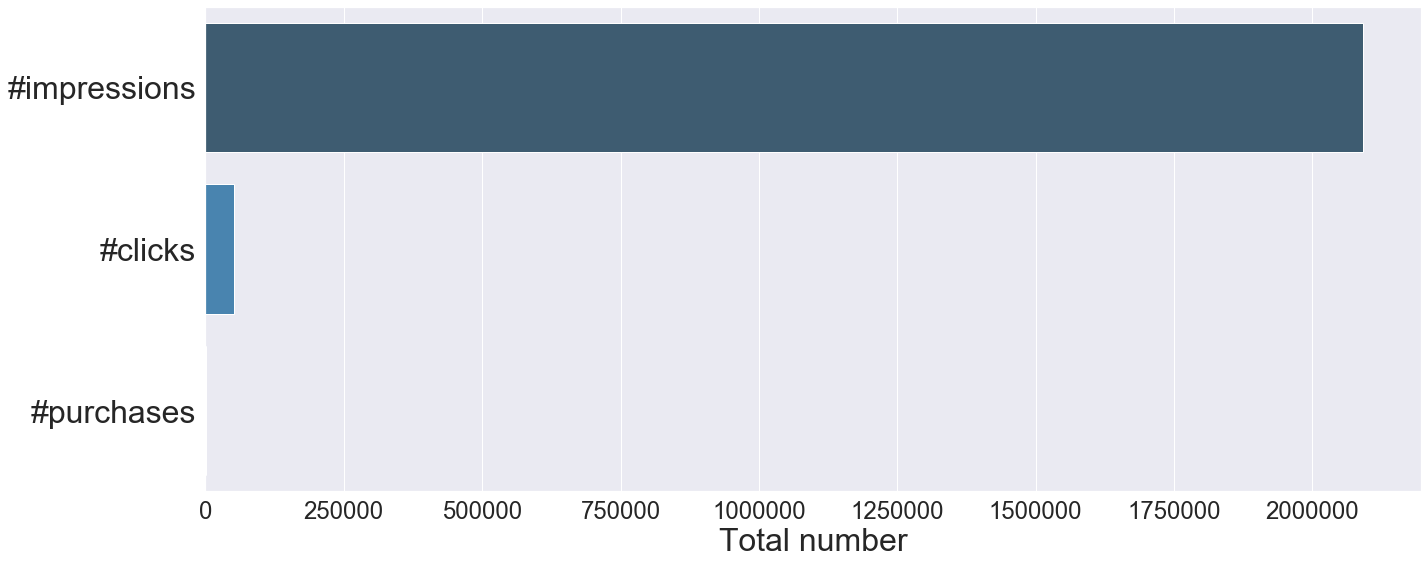

In [28]:
f, ax= plt.subplots(figsize=(20, 8))
ax = sns.barplot(y=['num_of_impressions','num_of_clicks', 'num_of_purchases'],
            x=[
                df_metrics['number_of_impressions'].sum(),
                df_metrics['number_of_clicks'].sum(),
                df_metrics['number_of_purchases'].sum()
            ],
            palette="Blues_d")
plt.ticklabel_format(style='plain', axis='x')
plt.xlabel('Total number', size=32)
ytics = ['#impressions', '#clicks', '#purchases']
plt.xticks(fontsize=24)
plt.yticks([0, 1, 2], ytics, fontsize=32)
plt.tight_layout()
ax.get_figure().savefig(tmp_fig_dir + "web-conversion-funnel.jpg")

In [29]:
# Aggregation by date
df_d_ni = df_i.groupby(['impressions_dt', 'os']).agg('count')['user_id'].reset_index()
df_d_ni = df_d_ni.rename(columns={'user_id': 'number_of_impressions'})

df_d_nc = df_c.groupby(['clicks_dt', 'os']).agg('count')['user_id'].reset_index()
df_d_nc = df_d_nc.rename(columns={'user_id': 'number_of_clicks'})

df_d_apm = df_apm.groupby(['purchase_dt', 'os']).agg('count')['user_id'].reset_index()
df_d_apm = df_d_apm.rename(columns={'user_id': 'number_of_purchases'})

In [30]:
df_d_metrics = pd.merge(left=df_d_ni, right=df_d_nc, how='inner', left_on=['impressions_dt', 'os'], right_on=['clicks_dt', 'os'])
df_d_metrics = pd.merge(left=df_d_metrics, right=df_d_apm, how='inner', left_on=['impressions_dt', 'os'], right_on=['purchase_dt', 'os'])
df_d_metrics.drop(['clicks_dt', 'purchase_dt'], axis=1, inplace=True)
df_d_metrics = df_d_metrics.rename(columns={'impressions_dt': 'event_dt'})

In [31]:
# corr
corr = df_d_metrics[['number_of_impressions', 'number_of_clicks', 'number_of_purchases']].corr()
corr

,number_of_impressions,number_of_clicks,number_of_purchases
number_of_impressions,1.000000,0.738405,-0.009378
number_of_clicks,0.738405,1.000000,-0.027706
number_of_purchases,-0.009378,-0.027706,1.000000


There is strong postive between "number_of_impressions" and "number_of_clicks" with coefficient of 0.74.

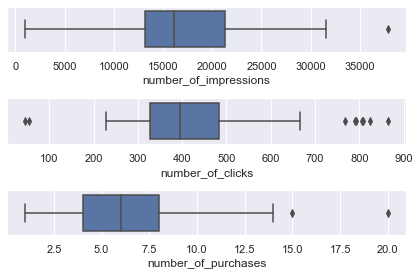

In [32]:
# outlier
f, axes = plt.subplots(3, 1)
sns.boxplot(df_d_metrics['number_of_impressions'], ax=axes[0])
sns.boxplot(df_d_metrics['number_of_clicks'], ax=axes[1])
sns.boxplot(df_d_metrics['number_of_purchases'], ax=axes[2])
f.tight_layout()

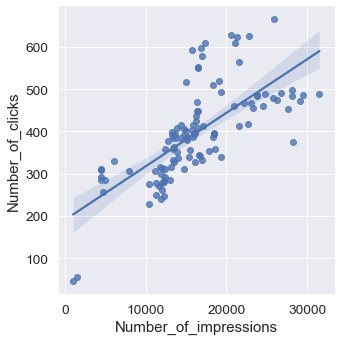

In [33]:
# lmplot 1
sns.set(font_scale = 1.25)
ax = sns.lmplot(x='number_of_impressions', y='number_of_clicks',data=df_d_metrics[df_d_metrics['number_of_clicks'] < 700][df_d_metrics['number_of_impressions'] < 35000])
ax.set(
    xlabel='Number_of_impressions',
    ylabel='Number_of_clicks',
    # title='num_of_impressions vs. num_of_clicks'
)
ax.savefig(tmp_fig_dir + "corr-num_impressions-vs-num_clicks.jpg")

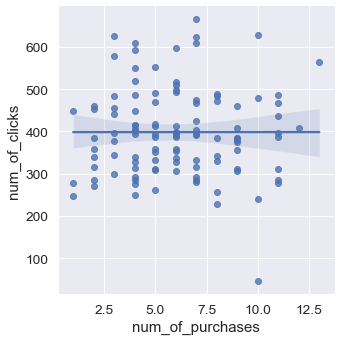

In [34]:
# lmplot 2
ax = sns.lmplot(x='number_of_purchases', y='number_of_clicks',data=df_d_metrics[df_d_metrics['number_of_clicks'] < 700][df_d_metrics['number_of_purchases'] < 14])
ax.set(
    xlabel='num_of_purchases',
    ylabel='num_of_clicks',
    # title='num_of_purchases vs. num_of_clicks'
)
ax.savefig(tmp_fig_dir + "corr-num_purchases-vs-num_clicks.jpg")

### 2.3 ROI per campaign

In [35]:
c_df_apm = pd.merge(left=df_apm, right=df_c, how='inner', left_on='click_id', right_on='action_id', suffixes=('', '_right'))
c_df_apm = c_df_apm[['os', 'campaign_id', 'user_id', 'revenue']].groupby(['os', 'campaign_id']).agg({'user_id': 'count', 'revenue': 'sum'}).reset_index()
c_df_apm = c_df_apm.rename(columns={'user_id': 'number_of_purchases', 'revenue': 'purchase_value'})
c_df_apm['purchase_value'] = c_df_apm.apply(lambda x: round(x['purchase_value'], 1), axis=1)

In [36]:
c_df_c = df_c[['os', 'campaign_id', 'user_id', 'click_cost']].groupby(['os', 'campaign_id']).agg({'user_id': 'count', 'click_cost': 'sum'}).reset_index()
c_df_c = c_df_c.rename(columns={'user_id': 'number_of_clicks', 'click_cost': 'spend'})

In [37]:
c_df_i = df_i[['os', 'campaign_id', 'user_id']].groupby(['os', 'campaign_id']).agg('count')['user_id'].reset_index()
c_df_i = c_df_i.rename(columns={'user_id': 'number_of_impressions'})
c_df_ic = pd.merge(left=c_df_i, right=camp_pho, on=['os', 'campaign_id'], how='left')
c_df1 = c_df_ic[['os', 'campaign_id', 'ham_group', 'number_of_impressions']]

In [38]:
# Join c_df_apm, c_df_c and c_df1
c_df1 = pd.merge(left=c_df1, right=c_df_c, on=['os', 'campaign_id'], how='left')
c_df1 = pd.merge(left=c_df1, right=c_df_apm, on=['os', 'campaign_id'], how='left')
c_df2 = c_df1.copy()

In [39]:
c_df1['CTR'] = c_df1.apply(lambda x: round(100 * x['number_of_clicks'] / x['number_of_impressions'], 2), axis=1)
c_df1['CPA'] = c_df1.apply(lambda x: round(x['spend'] / x['number_of_purchases'], 2), axis=1)
c_df1['ROAS'] = c_df1.apply(lambda x: round(x['purchase_value'] / x['spend'], 2), axis=1)

dump_data(c_df1, "ROI_per_campaign.csv")
# ROI per campaign table
c_df1

,os,campaign_id,ham_group,number_of_impressions,number_of_clicks,spend,number_of_purchases,purchase_value,CTR,CPA,ROAS
0,ANDROID,20614,HAM1-5,113192,9587,7681.90,100,5116.8,8.47,76.82,0.67
1,ANDROID,20615,HAM1-5,325943,2760,2089.80,18,1615.0,0.85,116.10,0.77
2,ANDROID,20616,HAM6-8,104015,8610,10288.45,159,9872.5,8.28,64.71,0.96
3,ANDROID,20617,HAM6-8,259522,2111,2489.80,52,2791.8,0.81,47.88,1.12
4,ANDROID,21319,HAM1-5,280460,3627,2292.90,28,2085.5,1.29,81.89,0.91
5,ANDROID,21320,HAM6-8,200403,2074,1992.60,28,2013.0,1.03,71.16,1.01
6,ANDROID,21562,HAM1-5,7784,621,248.40,13,631.7,7.98,19.11,2.54
7,ANDROID,21563,HAM6-8,6006,512,409.60,14,1115.2,8.52,29.26,2.72
8,IOS,20610,HAM1-5,88314,5501,5201.50,55,3699.9,6.23,94.57,0.71
9,IOS,20612,HAM6-8,340688,13672,16449.60,253,16146.8,4.01,65.02,0.98


### 2.4 Seasonality analysis

In [40]:
# clicks
df_c1 = df_c.groupby(['clicks_dt', 'os']).agg('count')['country']
df_c1 = df_c1.unstack('clicks_dt').transpose()
print(df_c1[df_c1['ANDROID'] < 100])  # show outliers for ANDROID cases

df_c['day_of_week'] = pd.to_datetime(df_c['clicks_dt']).dt.day_name()
df_c2 = df_c.groupby(['month_year', 'day_of_week', 'os']).agg('count')['country']
df_c2 = df_c2.unstack('month_year').unstack('day_of_week').transpose()
df_c2.head(5)

df_c3 = df_c.groupby(['month_year', 'clicks_hr', 'os']).agg('count')['country']
df_c3 = df_c3.unstack('month_year').unstack('clicks_hr').transpose()

os          ANDROID  IOS
clicks_dt               
2018-09-01       46  392
2018-09-02       55  357


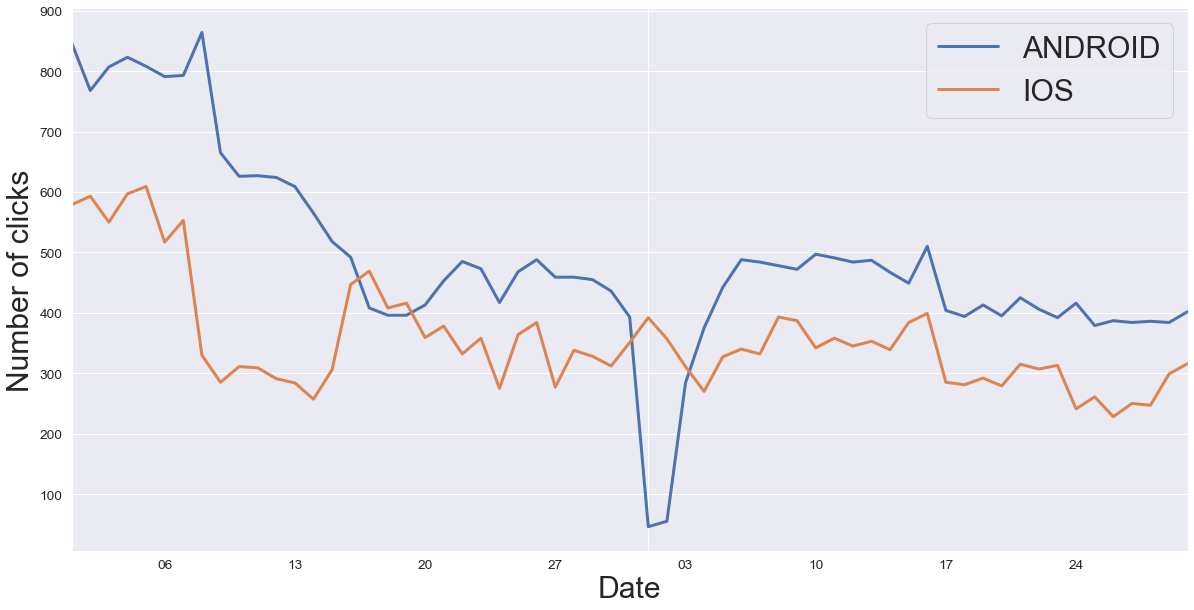

In [41]:
fig, ax1 = plt.subplots(figsize=(20,10))
df_c1.plot(ax=ax1, linewidth=3)
ax1.set_xlabel('Date', fontsize=30)
ax1.set_ylabel('Number of clicks', fontsize=30)
ax1.set_xticklabels([])
# hide x label only
# x_axis = ax1.axes.get_xaxis()
# x_label = x_axis.get_label()
# x_label.set_visible(False)
plt.xticks(fontsize=24)
ax1.legend(bbox_to_anchor=(1, 1), fontsize=30)
#x1.set_title('Number of clicks of over dates')
ax1.get_figure().savefig(tmp_fig_dir + "num_clicks_over_dates.jpg")

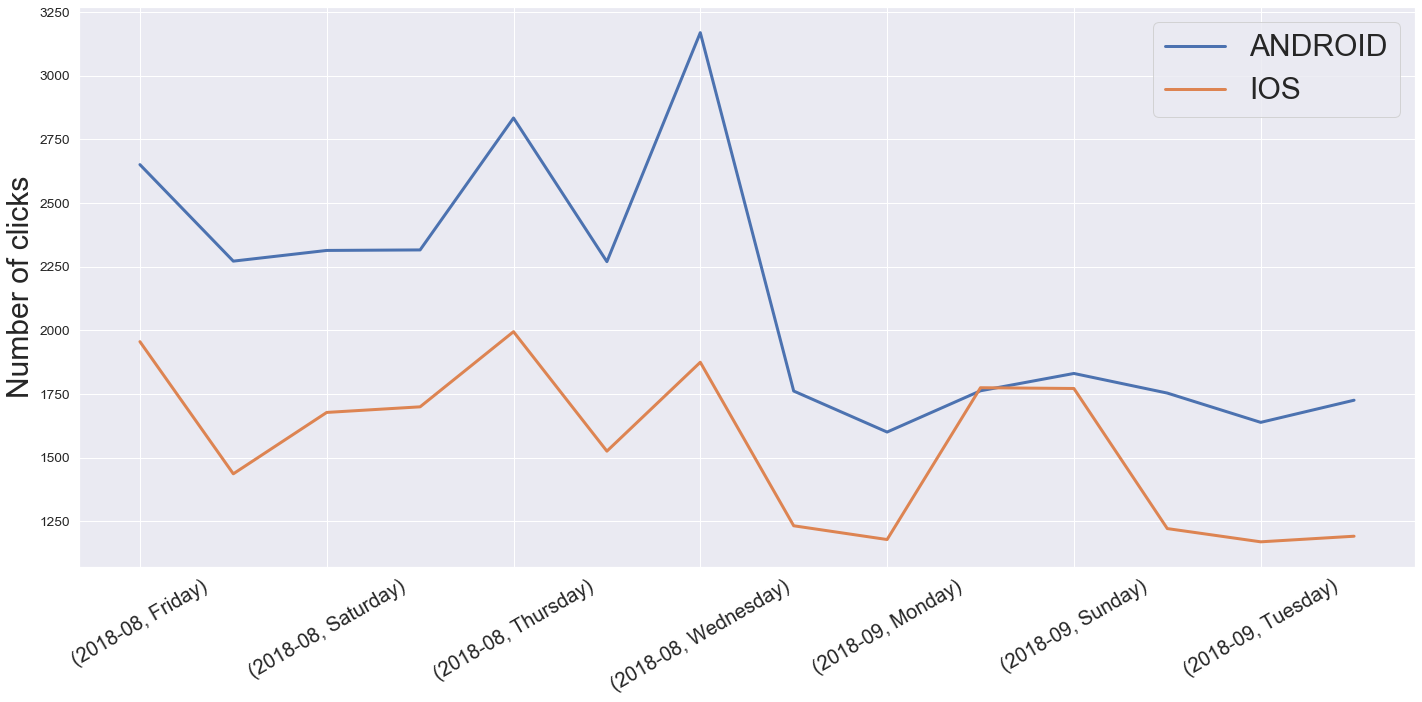

In [42]:
fig, ax2 = plt.subplots(figsize=(20,10))
df_c2.plot(ax=ax2, linewidth=3)
ax2.set_xlabel('Weekday', fontsize=24)
ax2.set_ylabel('Number of clicks', fontsize=30)
x_axis = ax2.axes.get_xaxis()
x_label = x_axis.get_label()
x_label.set_visible(False)
plt.xticks(fontsize=20, rotation=30)
ax2.legend(bbox_to_anchor=(1, 1), fontsize=30)
#x1.set_title('Number of clicks of over weekdays')
plt.tight_layout()
ax2.get_figure().savefig(tmp_fig_dir + "num_clicks_over_weekdays.jpg")

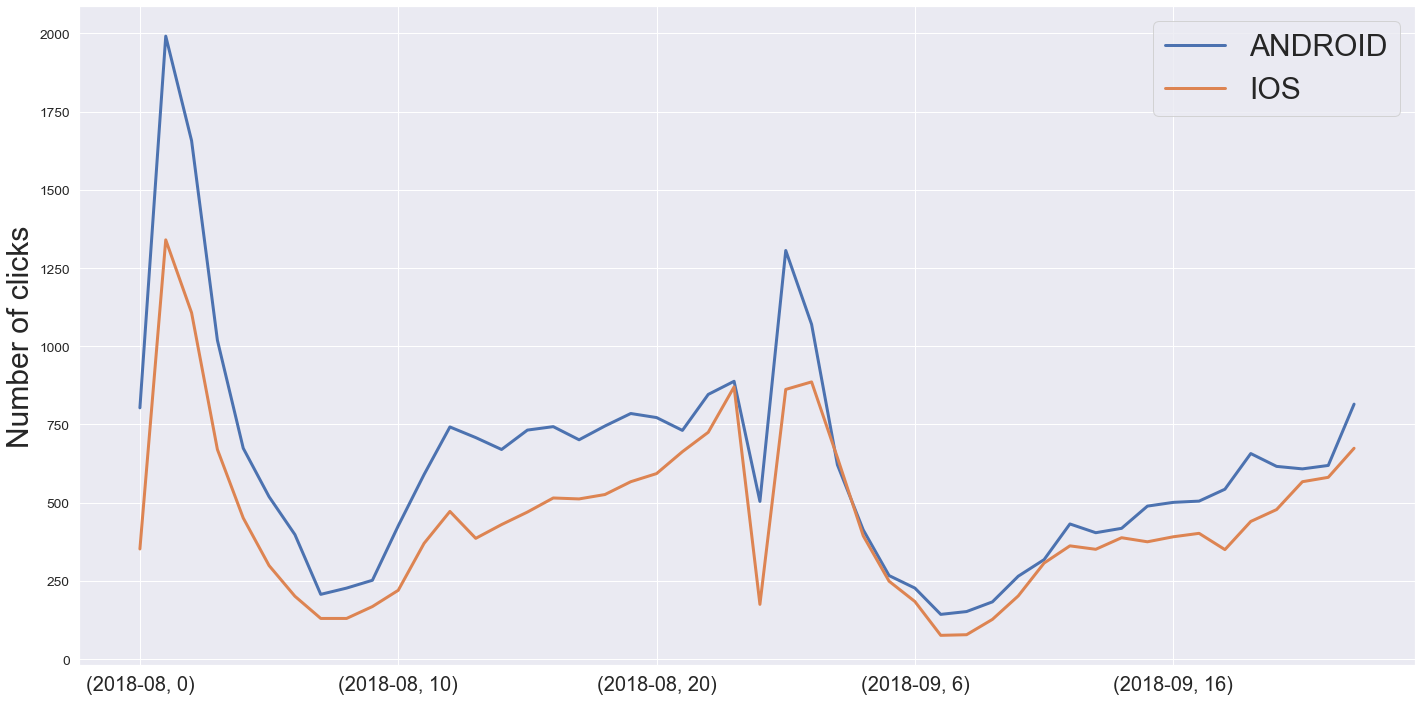

In [43]:
fig, ax3 = plt.subplots(figsize=(20,10))
df_c3.plot(ax=ax3, linewidth=3)
ax3.set_xlabel('Hour', fontsize=24)
ax3.set_ylabel('Number of clicks', fontsize=30)
x_axis = ax3.axes.get_xaxis()
x_label = x_axis.get_label()
x_label.set_visible(False)
plt.xticks(fontsize=20)
ax3.legend(bbox_to_anchor=(1, 1), fontsize=30)
#x1.set_title('Number of clicks of over hours')
plt.tight_layout()
ax3.get_figure().savefig(tmp_fig_dir + "num_clicks_over_hours.jpg")

- By dates:
  + Android: decrese throughout the first half of August, and then a dip on 09-01 (46) and 09-02 (55).
  + IOS: quite flat since mid-August
  
- By weekdays:
  + Android: Wed, Tr, Fr are top 3 in Aug, and similar in Sep.
  + IOS: Tr, Fr ar top 2 in Aug., and Sat, Sun tops in Sep.

- By Hours:
  + Android & IOS: share similar trend and most clicks happen around 1-3.
 
Questions:
- Any event around 09-01/02? (e.g. 09/03 is the labor day in 2018)
- What's the timezone used in the data?

In [44]:
# purchases
# check shrinkage of all_purchase_marketed table after purging
print(all_purchase_marketed.shape, df_apm.shape)
df_apm1 = df_apm.groupby(['purchase_dt', 'os']).agg('count')['country']
df_apm1 = df_apm1.unstack('purchase_dt').transpose()
print(df_apm1[df_apm1['ANDROID'] > 14])  # print peaks 
print(df_apm1[df_apm1['IOS'] > 12])  # print peaks

df_apm['day_of_week'] = pd.to_datetime(df_apm['purchase_dt']).dt.day_name()
df_apm2 = df_apm.groupby(['month_year', 'day_of_week', 'os']).agg('count')['country']
df_apm2 = df_apm2.unstack('month_year').unstack('day_of_week').transpose()

df_apm3 = df_apm.groupby(['month_year', 'purchase_hr', 'os']).agg('count')['country']
df_apm3 = df_apm3.unstack('month_year').unstack('purchase_hr').transpose()

(1116, 12) (762, 13)
os           ANDROID  IOS
purchase_dt              
2018-08-26      20.0  9.0
os           ANDROID   IOS
purchase_dt               
2018-08-25      11.0  15.0


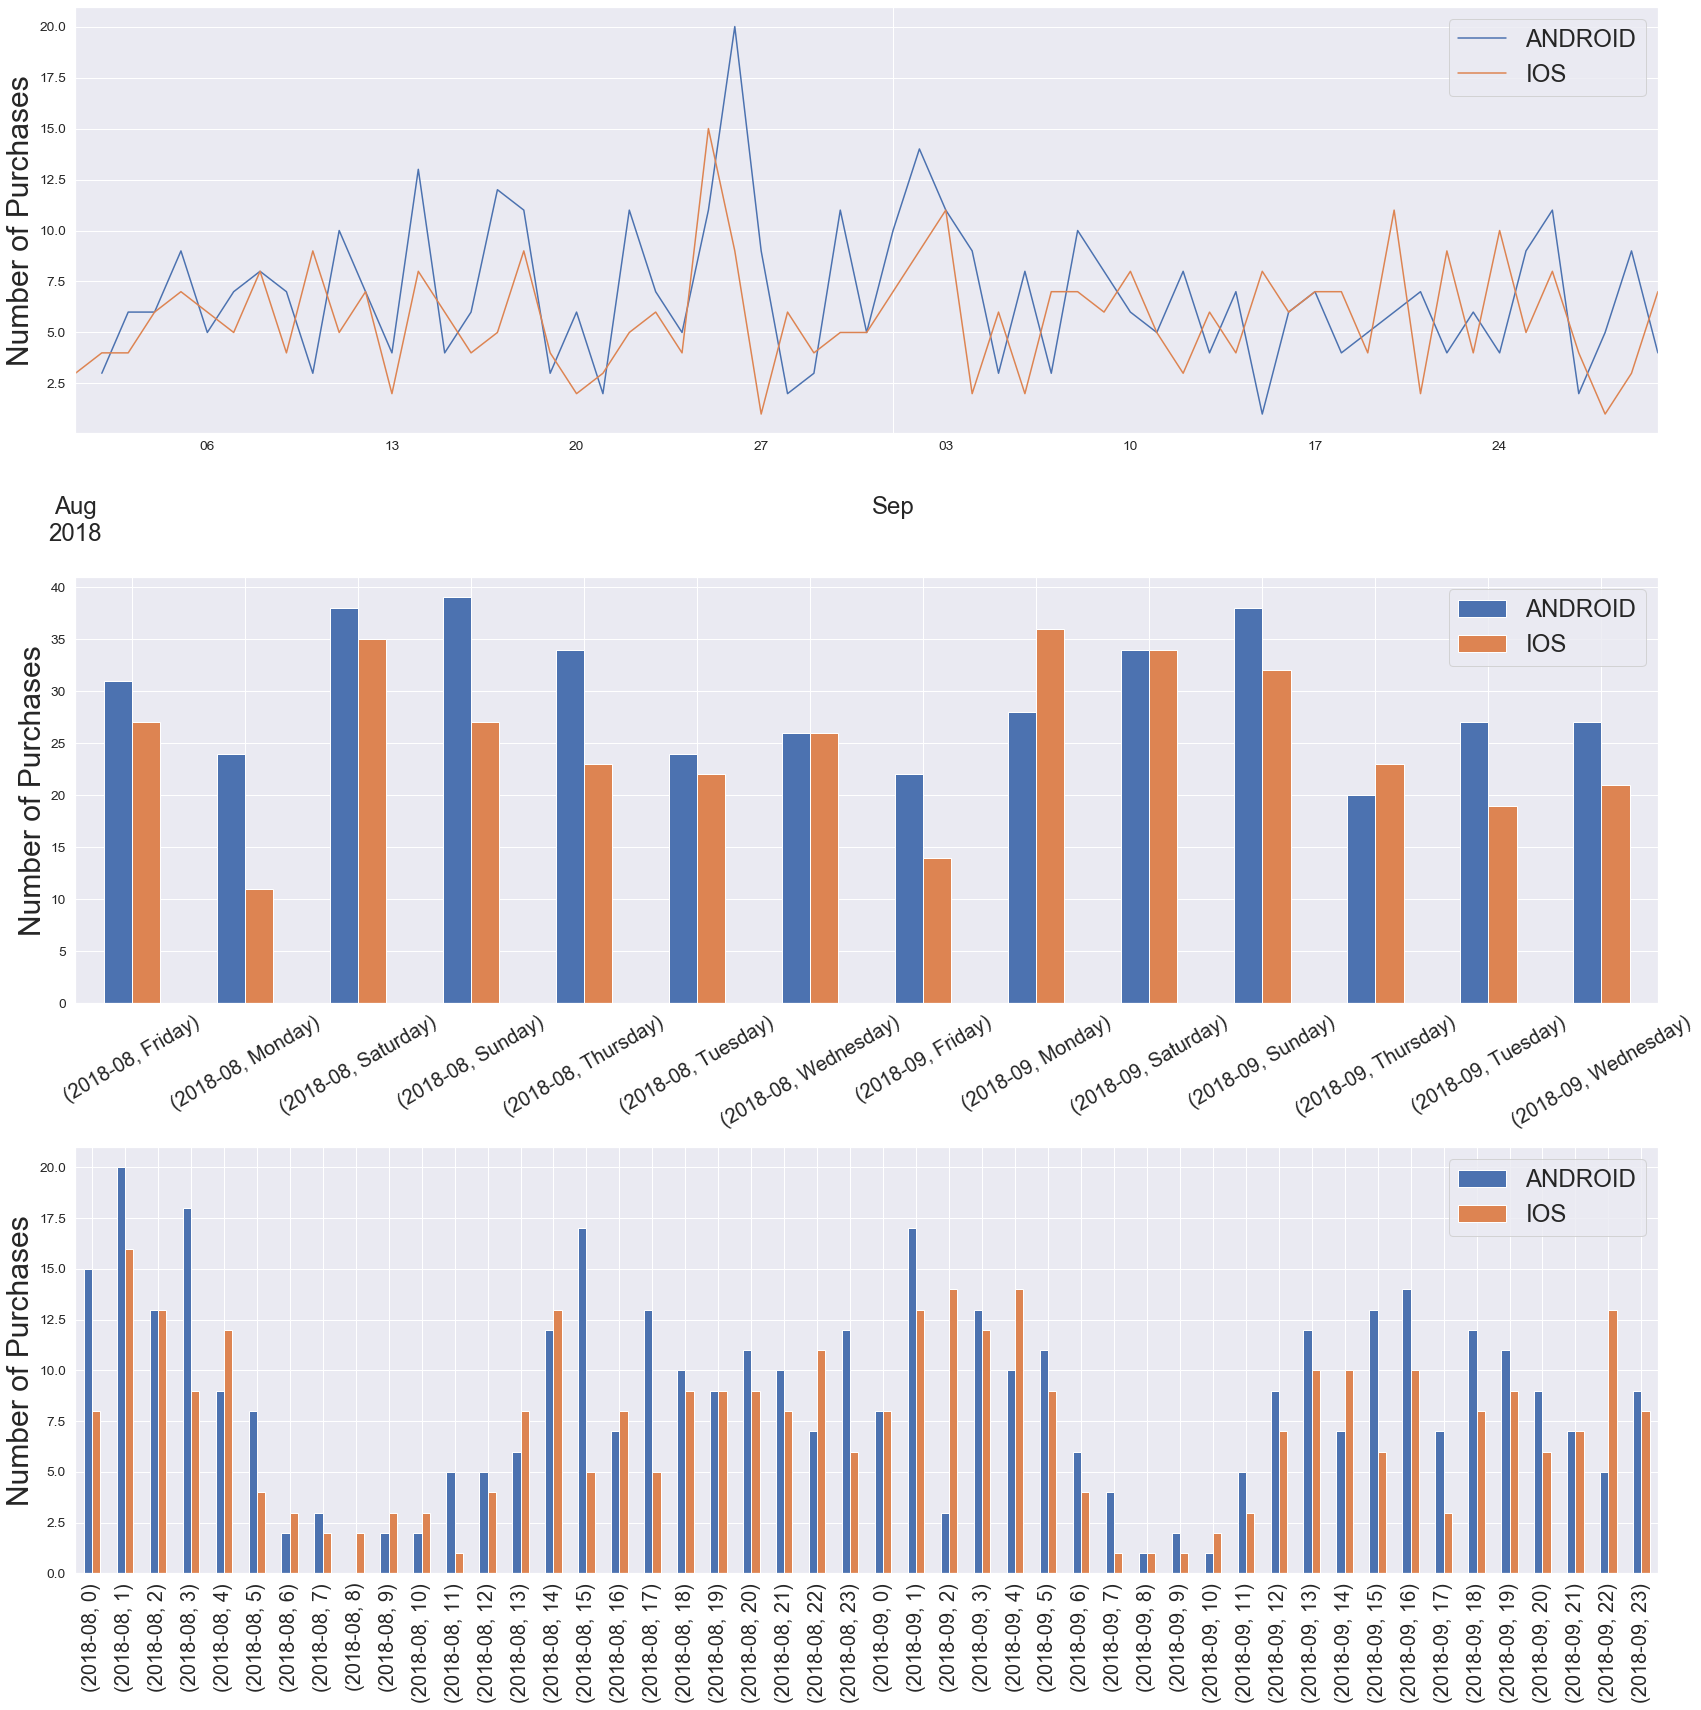

In [45]:
fig2 = plt.figure(figsize=(24,24))

ax1 = plt.subplot(311)
df_apm1.plot(ax=ax1)
ax1.legend(bbox_to_anchor=(1, 1), fontsize=24)
# ax1.set_title('Number of purchases of over dates')
ax1.set_xlabel('Date', fontsize=24)
ax1.set_ylabel('Number of Purchases', fontsize=30)
x_axis = ax1.axes.get_xaxis()
x_label = x_axis.get_label()
x_label.set_visible(False)
plt.xticks(fontsize=24)

ax2 = plt.subplot(312)
df_apm2.plot.bar(ax=ax2, rot=90)
ax2.legend(bbox_to_anchor=(1, 1), fontsize=24)
# ax2.set_title('Number of purchases of over weekdays')
ax2.set_xlabel('Weekday', fontsize=24)
ax2.set_ylabel('Number of Purchases', fontsize=30)
x_axis = ax2.axes.get_xaxis()
x_label = x_axis.get_label()
x_label.set_visible(False)
plt.xticks(fontsize=20, rotation=30)

ax3 = plt.subplot(313)
df_apm3.plot.bar(ax=ax3, rot=90)
ax3.legend(bbox_to_anchor=(1, 1), fontsize=24)
# ax3.set_title('Number of purchases of over hours')
ax3.set_xlabel('Hour', fontsize=24)
ax3.set_ylabel('Number of Purchases', fontsize=30)
x_axis = ax3.axes.get_xaxis()
x_label = x_axis.get_label()
x_label.set_visible(False)
plt.xticks(fontsize=20)

fig2.tight_layout()
ax3.get_figure().savefig(tmp_fig_dir + "num_purchases_seasonality.jpg")

- By dates:
  + AND reaches highest on 08-26 (20) and IOS reaches highest on 08-25 (15). 

### 2.5 Comparison between organic vs. marketed

In [46]:
# marketed_custom_actions ("purchase" vs. "non-purchase")
print(marketed_custom_actions.shape)
print(df_mca.shape)
print(all_purchase_organic.shape)
print(all_purchase_marketed.shape)

(517802, 13)
(768, 13)
(140708, 12)
(1116, 12)


In [47]:
all_purchase['is_organic'] = all_purchase.apply(lambda x: True if pd.isnull(x.click_id) else False, axis=1)
all_purchase['day_of_week'] = pd.to_datetime(all_purchase['purchase_dt']).dt.day_name()
all_purchase['month_year'] = pd.to_datetime(all_purchase['purchase_dt']).dt.to_period('M')
all_purchase.is_organic.value_counts()
df_organic = all_purchase.loc[all_purchase['is_organic'] == True]
df_marketed = all_purchase.loc[all_purchase['is_organic'] == False]
print(all_purchase.shape, df_organic.shape, df_marketed.shape)

(141824, 15) (140708, 15) (1116, 15)


In [48]:
df_o_1 = df_organic.groupby(['purchase_dt', 'os']).agg('count')['country']
df_o_1 = df_o_1.unstack('purchase_dt').transpose()
df_m_1 = df_marketed.groupby(['purchase_dt', 'os']).agg('count')['country']
df_m_1 = df_m_1.unstack('purchase_dt').transpose()

df_o_2 = df_organic.groupby(['day_of_week', 'os']).agg('count')['country']
df_o_2 = df_o_2.unstack('day_of_week').transpose()
df_m_2 = df_marketed.groupby(['day_of_week', 'os']).agg('count')['country']
df_m_2 = df_m_2.unstack('day_of_week').transpose()
# print(df_organic.day_of_week.value_counts())
df_o_3 = df_organic.groupby(['purchase_hr', 'os']).agg('count')['country']
df_o_3 = df_o_3.unstack('purchase_hr').transpose()
df_m_3 = df_marketed.groupby(['purchase_hr', 'os']).agg('count')['country']
df_m_3 = df_m_3.unstack('purchase_hr').transpose()

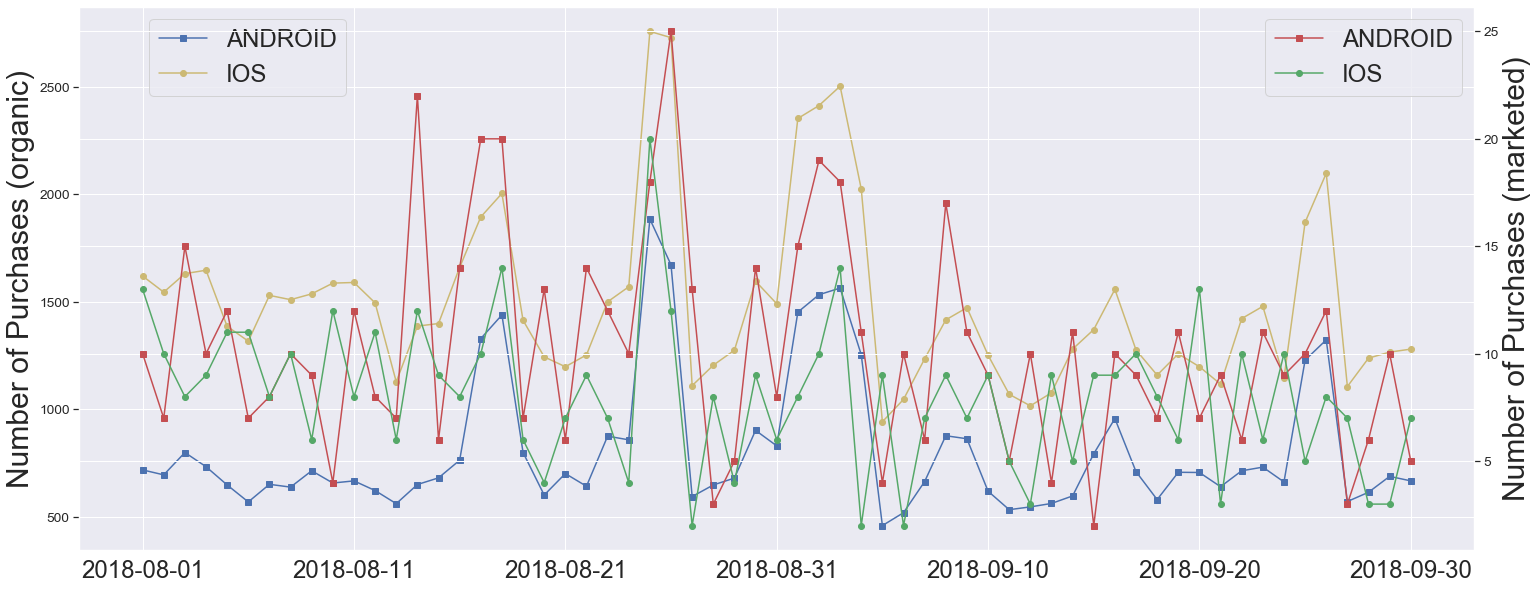

In [49]:
styles1 = ['bs-','yo-','y^-']
styles2 = ['rs-','go-','b^-']
fig, ax1 = plt.subplots(figsize=(25,10))
# fig.suptitle('The comparison between organic and marketed', fontsize=16)
ax1.set_xlabel('Time Period', fontsize=30)
ax1.set_ylabel('Number of Purchases (organic)', fontsize=30)
df_o_1.plot(ax=ax1, style=styles1)
ax1.legend(bbox_to_anchor=(0.2, 1), fontsize=24)
x_axis = ax1.axes.get_xaxis()
x_label = x_axis.get_label()
x_label.set_visible(False)
plt.xticks(fontsize=24)

ax2 = ax1.twinx()
ax2.set_ylabel('Number of Purchases (marketed)', fontsize=30)
df_m_1.plot(ax=ax2, style=styles2)
ax2.legend(bbox_to_anchor=(1, 1), fontsize=24)
x_axis = ax2.axes.get_xaxis()
x_label = x_axis.get_label()
x_label.set_visible(False)
ax2.get_figure().savefig(tmp_fig_dir + "num_purchases_marketed-vs-organic_over_date.jpg")

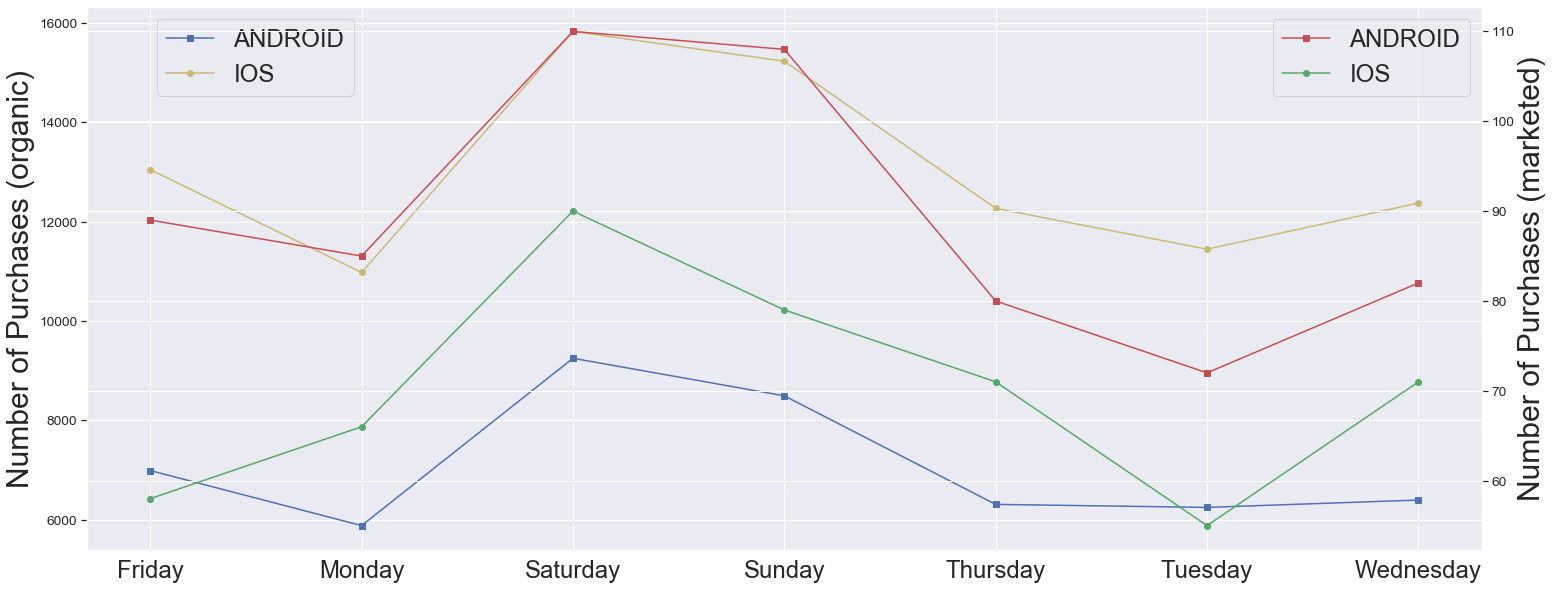

In [50]:
fig, ax1 = plt.subplots(figsize=(25,10))
# fig.suptitle('The comparison between organic and marketed', fontsize=16)
#color = 'tab:cyan'
ax1.set_xlabel('Weekday', fontsize=24)
ax1.set_ylabel('Number of Purchases (organic)', fontsize=30)
df_o_2.plot(ax=ax1, style=styles1)
ax1.legend(bbox_to_anchor=(0.2, 1), fontsize=24)
x_axis = ax1.axes.get_xaxis()
x_label = x_axis.get_label()
x_label.set_visible(False)
plt.xticks(fontsize=24)

ax2 = ax1.twinx()
#color = 'tab:purple'
ax2.set_ylabel('Number of Purchases (marketed)', fontsize=30)
df_m_2.plot(ax=ax2, style=styles2)
ax2.legend(bbox_to_anchor=(1, 1), fontsize=24)
x_axis = ax2.axes.get_xaxis()
x_label = x_axis.get_label()
x_label.set_visible(False)
ax2.get_figure().savefig(tmp_fig_dir + "num_purchases_marketed-vs-organic_over_weekday.jpg")

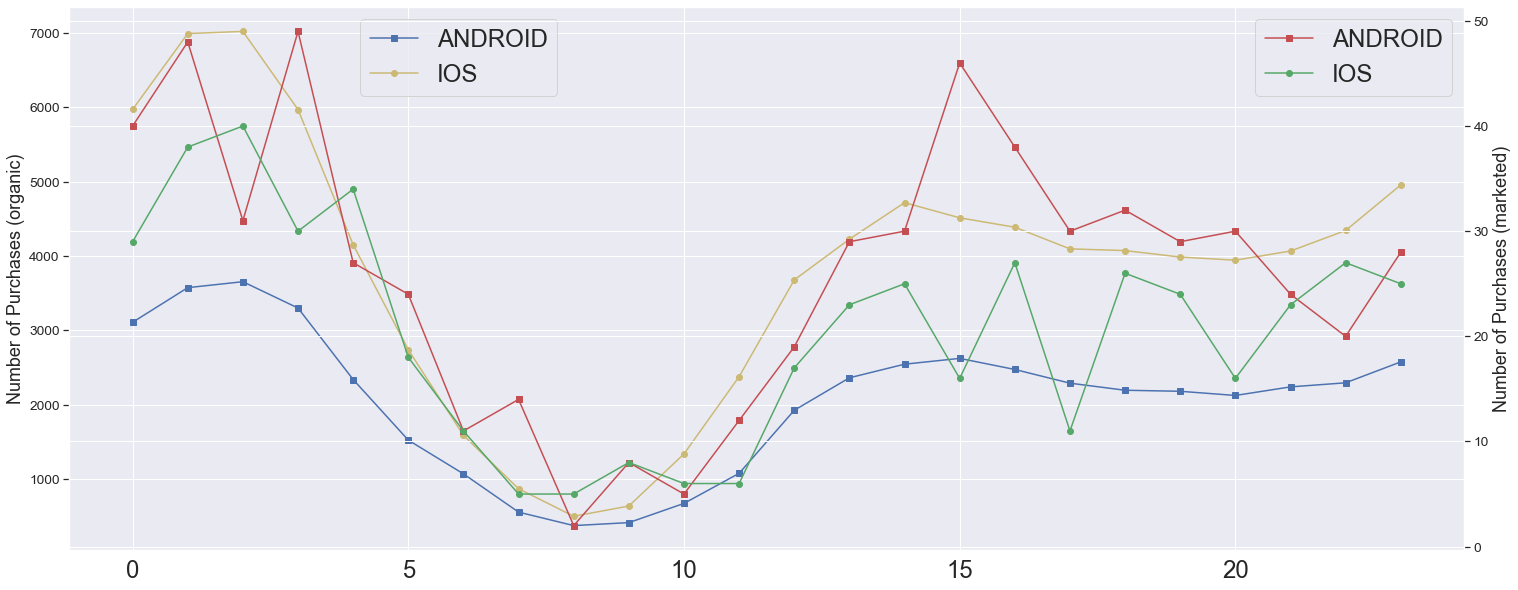

In [51]:
fig, ax1 = plt.subplots(figsize=(25,10))
# fig.suptitle('The comparison between organic and marketed', fontsize=24)
#color = 'tab:cyan'
ax1.set_xlabel('Weekday', fontsize=24)
ax1.set_ylabel('Number of Purchases (organic)', fontsize=18)
df_o_3.plot(ax=ax1, style=styles1)
ax1.legend(bbox_to_anchor=(0.2, 1), fontsize=24)
x_axis = ax1.axes.get_xaxis()
x_label = x_axis.get_label()
x_label.set_visible(False)
plt.xticks(fontsize=24)

ax2 = ax1.twinx()
#color = 'tab:purple'
ax2.set_ylabel('Number of Purchases (marketed)', fontsize=18)
df_m_3.plot(ax=ax2, style=styles2)
ax2.legend(bbox_to_anchor=(1, 1), fontsize=24)
ax2.legend(bbox_to_anchor=(1, 1), fontsize=24)
x_axis = ax2.axes.get_xaxis()
x_label = x_axis.get_label()
x_label.set_visible(False)
ax2.get_figure().savefig(tmp_fig_dir + "num_purchases_marketed-vs-organic_over_weekday.jpg")

The trend fluctuated with dates and hours. For example, there is peak during late night (or early morning) and weekends.

## 3. Customer Analytics

### 3.1 Churn rate

In [52]:
df_cr = all_purchase[['purchase_dt', 'user_id']].groupby('purchase_dt').agg({'user_id': pd.Series.nunique})
df_cr = df_cr.rename(columns = {'user_id':'num_users'})
df_cr.reset_index('purchase_dt',inplace=True)
df_cr.head(3)

,purchase_dt,num_users
0,2018-08-01,2011
1,2018-08-02,1948
2,2018-08-03,2121


In [53]:
df_cr['last_num_users'] = df_cr['num_users'].shift(periods=1)
df_cr['num_churned'] = df_cr['last_num_users'] - df_cr['num_users']
df_cr['churn_rate'] = df_cr['num_churned']/df_cr['last_num_users']
df_cr.drop('last_num_users',axis=1,inplace=True)
df_cr.head(3)

,purchase_dt,num_users,num_churned,churn_rate
0,2018-08-01,2011,NaN,NaN
1,2018-08-02,1948,63.0,0.031328
2,2018-08-03,2121,-173.0,-0.088809


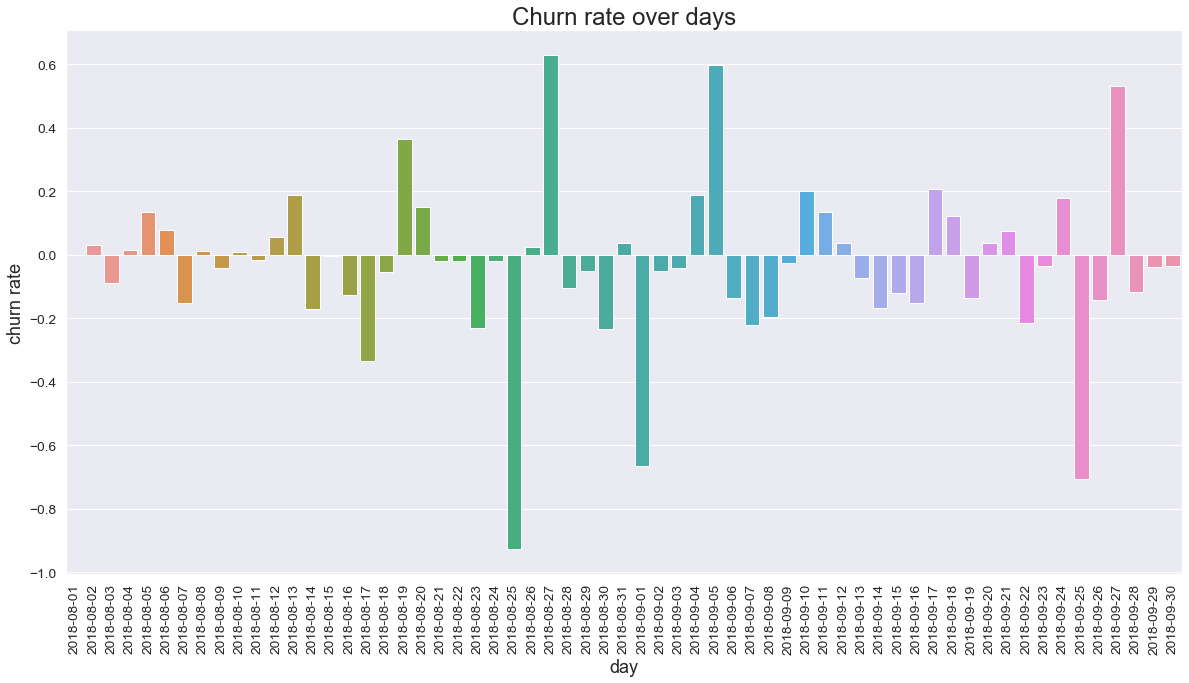

In [54]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(df_cr.purchase_dt, df_cr.churn_rate)
plt.title('Churn rate over days', size=24)
ax.tick_params(axis="x", rotation=90)
plt.ylabel('churn rate', size=18)
plt.xlabel('day', size=18)
plt.show()
ax.get_figure().savefig(tmp_fig_dir + "churn-rate-over-dates.jpg")

### 3.2 Retention rate

In [55]:
def get_cohort_period(df):
    df['cohort_period'] = np.arange(len(df)) + 1
    return df

def gen_cohorts(df):
    df_rr = df
    df_rr['purchase_date'] = df_rr['purchase_dt'].dt.to_period('D')
    df_rr['cohort_date'] = df_rr.groupby('user_id')['purchase_date'].transform('min')
    grouped = df_rr.groupby(['cohort_date', 'purchase_date'])
    cohorts = grouped.agg({'user_id': pd.Series.nunique,
                          'action_id': pd.Series.nunique})
    cohorts.rename(columns={'user_id':'total_users',
                           'action_id':'total_purchases'}, inplace=True)
    cohorts = cohorts.groupby(level=0).apply(get_cohort_period)
    return cohorts

In [56]:
def draw_retention_rates(cohorts, name):
    cohorts.reset_index(inplace=True)
    cohorts.set_index(['cohort_date', 'cohort_period'], inplace=True)
    cohort_sizes = cohorts.groupby(level=0)['total_users'].first()

    user_retention = cohorts['total_users'].unstack(0).divide(cohort_sizes, axis=1)
    plt.figure(figsize=(30,20))
    ax = sns.heatmap(user_retention, annot=True,cmap="YlGnBu", fmt='.0%')

    ax.set_ylabel('Cohort Period', fontsize=24)
    ax.set_xlabel('Cohort Group', fontsize=24)
    ax.set_title('Retention rates across cohorts', fontsize=30)
    # plt.show()
    ax.get_figure().savefig(tmp_fig_dir + f"retention-rate-across-cohort-{name}.jpg")

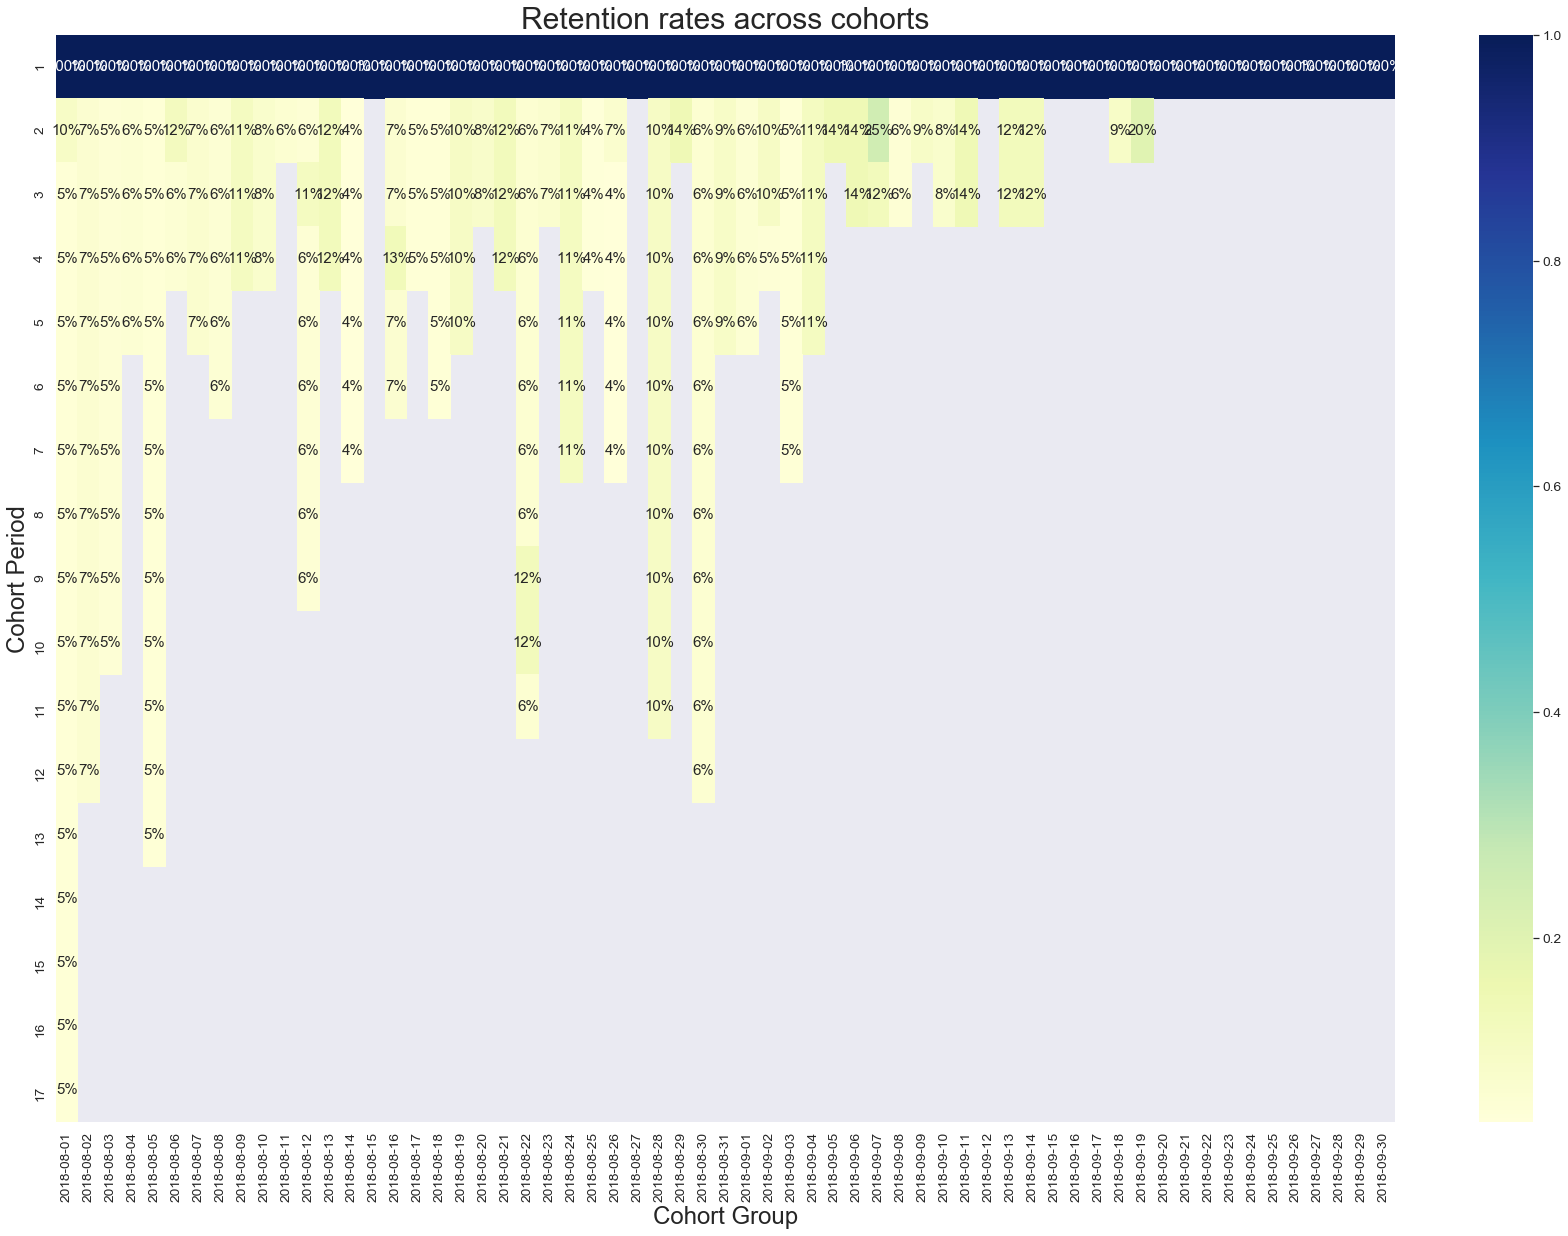

In [57]:
# draw marketed
apm_rr = all_purchase_marketed
apm_rr['purchase_dt'] = pd.to_datetime(apm_rr['purchase_dt'])
cohorts_marketed = gen_cohorts(apm_rr)
draw_retention_rates(cohorts_marketed, "marketed")

The retention rate is less than 10% in most cases, which means, over 90% customers will not purchase again.

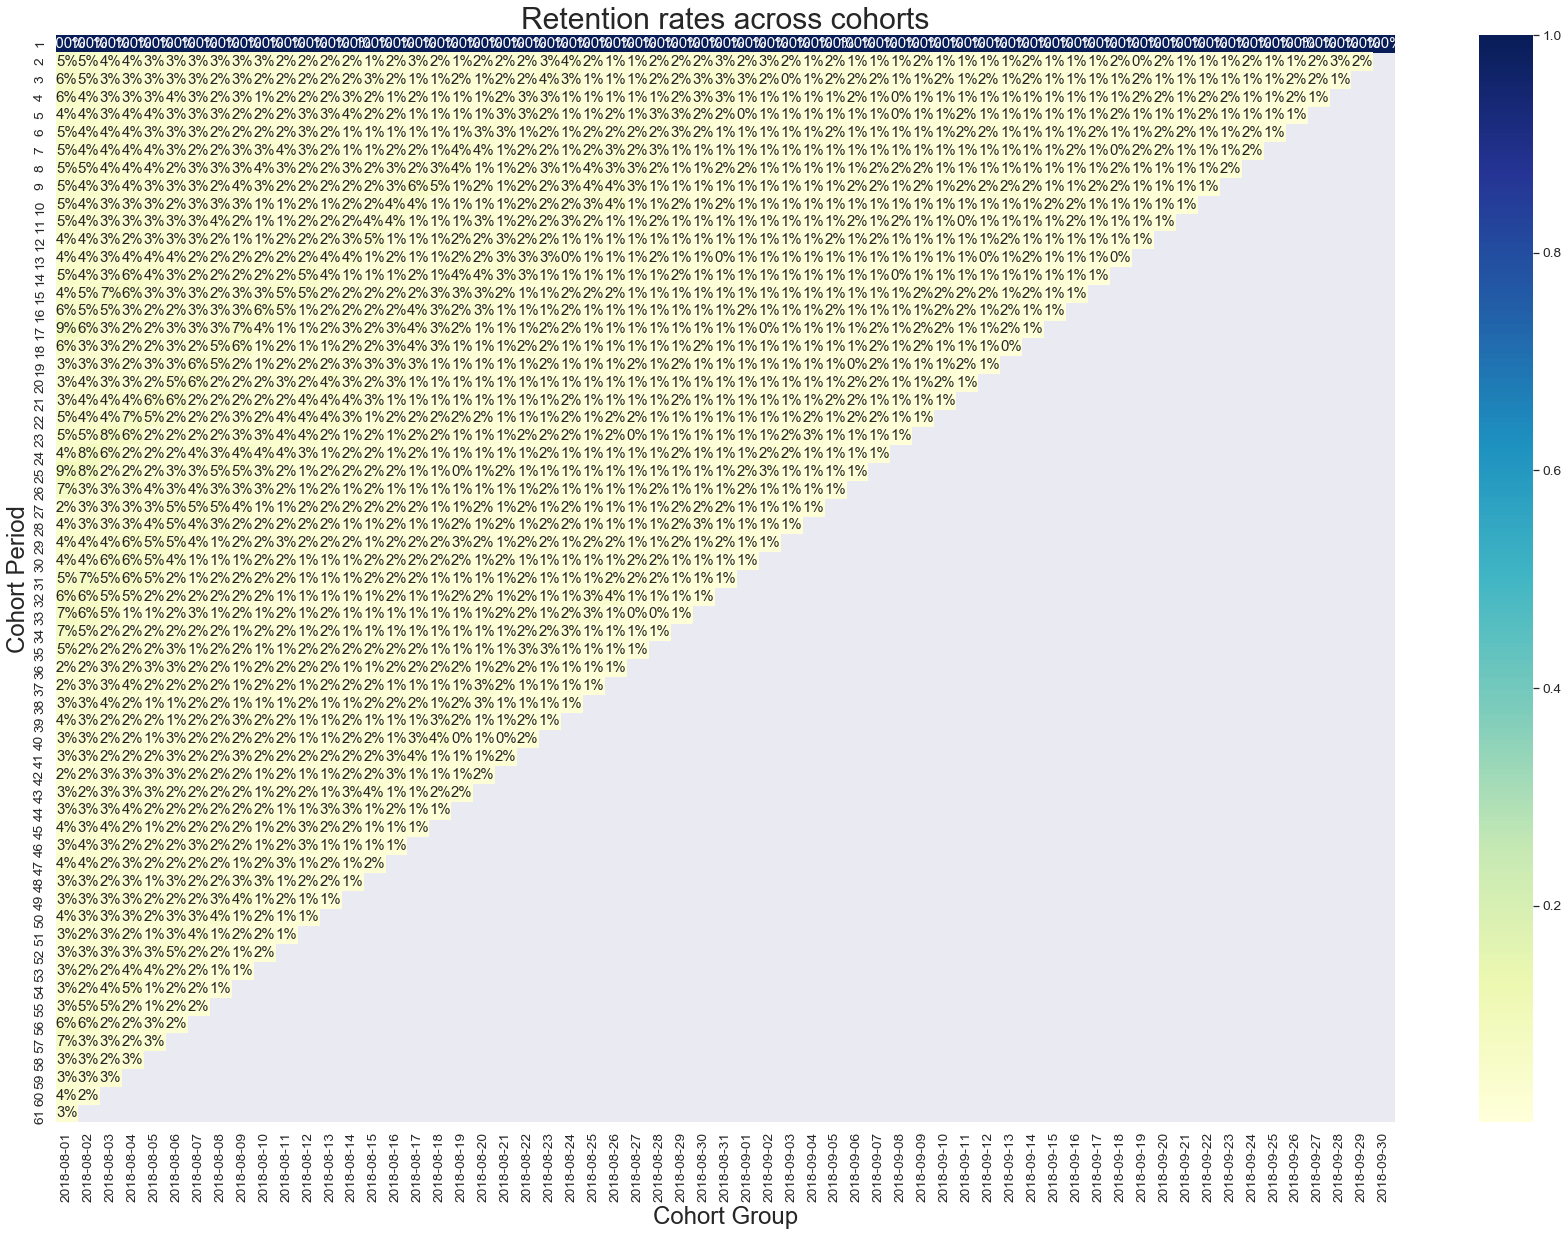

In [58]:
# draw organic for reference
apo_rr = all_purchase_organic
apo_rr['purchase_dt'] = pd.to_datetime(apo_rr['purchase_dt'])
cohorts_organic = gen_cohorts(apo_rr)
draw_retention_rates(cohorts_organic, "organic")

### 3.3 RFM Analysis
https://www.investopedia.com/terms/r/rfm-recency-frequency-monetary-value.asp#:~:text=Recency%2C%20frequency%2C%20monetary%20value%20is,a%20customer%20makes%20a%20purchase

In [59]:
_cols_left, _cols_right = list(all_purchase_marketed.columns), list(marketed_custom_actions)
df_rfm1 = pd.merge(left=all_purchase_marketed, right=marketed_custom_actions, how='inner', left_on=['click_id', 'purchase_name', 'os', 'country'], right_on=['click_id', 'custom_action', 'os', 'country'], suffixes=('', '_right'))
list_diff(_cols_left, _cols_right)
print(len(all_purchase_marketed), len(marketed_custom_actions), len(df_rfm1))
df_rfm1.head()

la:  14 lb:  13
la-lb (items in first list only):  11
lb-la (items in second list only):  10
la&lb (items in both first and second lists):  3

1116 517802 1317


,timestamp,action_id,os,user_id,click_id,attribution_id,session_id,purchase_name,revenue,country,purchase_dt,purchase_hr,purchase_date,cohort_date,campaign_id,creative_id,creative_format,app_id,supplier_id,custom_action,value,time_event,day_action,device_id
0,1538347004,Ttb2sMUBEeiAHWuvjYMJ4g,IOS,953f5b879d796fe9990dfaace174afd9ee1ea455,_KJkcMQyEeihGweSCecPMg,44f6409561f5fd8aa4d296bb552a004b,1461505975000-7848190,af_purchase,0.000000,US,2018-09-30,22,2018-09-30,2018-09-30,20610,115823,177293,1082462952,335,af_purchase,0,2018-09-30 22:36:44.000000,2018-09-30,30189fe1e27b36f904600f2fd27df1faf04dddfc
1,1538339626,IUJ6AMTwEeiZTQvoTtlKKQ,ANDROID,a125c4e4dcc449d8047876f14a6d55bf82eb65e8,B8o9cMNzEeixUrf7YKp26A,6e115ca35ee6f64ae1bc94a79971ef2d,1523131426162-1925112809294030154,af_purchase,53.470000,US,2018-09-30,20,2018-09-30,2018-09-30,20617,114424,165835,com.surpax.ledflashlight.panel,333,af_purchase,53,2018-09-30 20:33:46.000000,2018-09-30,8628dd0e83c75bc96cf2be8ca5afa824e1877f12
2,1538339966,6-RokMTwEeiFFMshcaot5Q,ANDROID,fe2721d933e92fd41a13017888a7ba3300649e13,7p2OAMRUEeihwmN_7dDaxw,58747985c49c660c6f6912e8205afb65,1523553840539-6427613840977701130,first purchase,85.810000,US,2018-09-30,20,2018-09-30,2018-09-30,21563,114586,166663,com.zentertain.photocollage,335,first purchase,86,2018-09-30 20:39:26.000000,2018-09-30,c1c2ee9a90755bdec641d675cf91288602414a04
3,1538339966,69gzkMTwEeijzdMjOybClw,ANDROID,fe2721d933e92fd41a13017888a7ba3300649e13,7p2OAMRUEeihwmN_7dDaxw,58747985c49c660c6f6912e8205afb65,1523553840539-6427613840977701130,af_purchase,85.810000,US,2018-09-30,20,2018-09-30,2018-09-30,21563,114586,166663,com.zentertain.photocollage,335,af_purchase,86,2018-09-30 20:39:26.000000,2018-09-30,c1c2ee9a90755bdec641d675cf91288602414a04
4,1538323240,-nLToMTJEeiVBYE7r7w8cg,IOS,3c891f115b9f3ba092a492eb94bbe40843b44828,hmtD8MROEeivMV0aEd9MRQ,0feb75dd2fcd6c5e2976c9d035783f71,1526598859026-8218078,af_purchase,60.970001,US,2018-09-30,16,2018-09-30,2018-09-30,20612,115823,177293,1347684152,335,af_purchase,61,2018-09-30 16:00:40.000000,2018-09-30,6971206bf0307155f0df2c4535e06a6e6e3e0c53


In [60]:
last_date = dt.datetime(2018, 10, 1)
# TODO: choose proper feature as frequency
frequency_feature = 'click_id' 
df_rfm2 = df_rfm1.groupby('user_id').agg({'purchase_dt': lambda x: (last_date - x.max()).days, 
                                         frequency_feature: lambda x: len(x),
                                         'revenue': lambda x: x.sum()})
df_rfm2.rename(columns={'purchase_dt': 'recency',
                   'click_id': 'frequency',
                   'revenue': 'monetary'}, inplace=True)
df_rfm2 = df_rfm2.reset_index()
df_rfm2.head()

,user_id,recency,frequency,monetary
0,003dd4d5f7b64908cd92c08a18690112cec30098,59,1,60.950000
1,008aec731756d251be4ac4dbba639875e7c6d1aa,11,1,69.980003
2,00f1abd990e584e252215bfb66266157c39b7092,52,1,55.259998
3,016d49c4f11fd44d88270d62a4615d79cb7c21c9,21,1,49.520000
4,0183a9f56e3157fcb6ce3a1dfdf47af3f9bfcd01,6,1,37.980000


In [61]:
df_rfm2.describe()

,recency,frequency,monetary
count,743.000000,743.000000,743.000000
mean,31.960969,1.772544,136.559017
std,17.681743,3.624668,831.631849
min,1.000000,1.000000,0.000000
25%,16.000000,1.000000,28.000000
50%,32.000000,1.000000,60.970001
75%,47.000000,1.500000,116.825000
max,61.000000,80.000000,21885.160000


In [62]:
# TODO: remove "outlier" users
f_thres = 20.0
m_thres = 2000.0
print(f"Before removing 'outlier': {len(df_rfm2)}")
print(df_rfm2[df_rfm2['monetary'] > m_thres].monetary)
print(df_rfm2[df_rfm2['frequency'] > f_thres].frequency)
df_rfm2.drop(df_rfm2[(df_rfm2['monetary'] > m_thres) | (df_rfm2['frequency'] > f_thres)].index, inplace=True)
print(f"After removing 'outlier': {len(df_rfm2)}")

Before removing 'outlier': 743
374     4875.810000
385     2275.040036
572    21885.160000
Name: monetary, dtype: float64
238    43
572    80
Name: frequency, dtype: int64
After removing 'outlier': 739


In [63]:
df_rfm2.describe()

,recency,frequency,monetary
count,739.000000,739.000000,739.000000
mean,31.991881,1.592693,96.227199
std,17.665668,1.567972,119.555706
min,1.000000,1.000000,0.000000
25%,16.000000,1.000000,27.474999
50%,32.000000,1.000000,60.950000
75%,47.000000,1.000000,115.420000
max,61.000000,17.000000,1000.610000


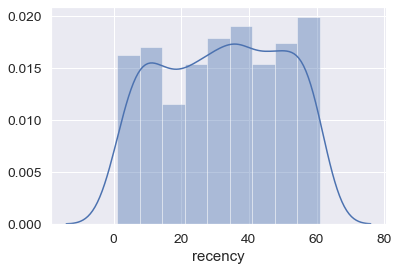

In [64]:
sns.distplot(df_rfm2['recency'])

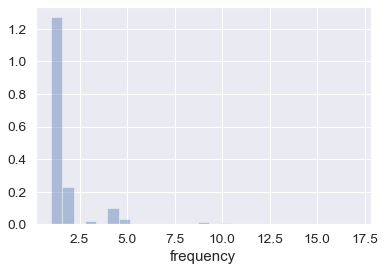

In [65]:
sns.distplot(df_rfm2['frequency'])

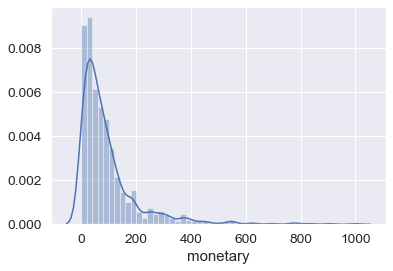

In [66]:
sns.distplot(df_rfm2['monetary'])

In [67]:
# Segmentation by quantiles
quantiles = df_rfm2.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
pprint(quantiles)

{'frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'monetary': {0.25: 27.4749995, 0.5: 60.95, 0.75: 115.42},
 'recency': {0.25: 16.0, 0.5: 32.0, 0.75: 47.0}}


In [68]:
# define R, F, M scores
def Rscore(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4
    
def Fscore(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1
    
def Mscore(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [69]:
# Apply scores
df_rfm2['R'] = df_rfm2['recency'].apply(Rscore, args=('recency', quantiles))
df_rfm2['F'] = df_rfm2['frequency'].apply(Fscore, args=('frequency', quantiles))
df_rfm2['M'] = df_rfm2['monetary'].apply(Mscore, args=('monetary', quantiles))
df_rfm2.head()

,user_id,recency,frequency,monetary,R,F,M
0,003dd4d5f7b64908cd92c08a18690112cec30098,59,1,60.950000,4,4,3
1,008aec731756d251be4ac4dbba639875e7c6d1aa,11,1,69.980003,1,4,2
2,00f1abd990e584e252215bfb66266157c39b7092,52,1,55.259998,4,4,3
3,016d49c4f11fd44d88270d62a4615d79cb7c21c9,21,1,49.520000,2,4,3
4,0183a9f56e3157fcb6ce3a1dfdf47af3f9bfcd01,6,1,37.980000,1,4,3


In [70]:
# Add RFMGroup and RFMScore
df_rfm2['RFMGroup'] = df_rfm2.R.map(str) + df_rfm2.F.map(str) + df_rfm2.M.map(str)
df_rfm2['RFMScore'] = df_rfm2[['R', 'F', 'M']].sum(axis = 1)
df_rfm2.head()

,user_id,recency,frequency,monetary,R,F,M,RFMGroup,RFMScore
0,003dd4d5f7b64908cd92c08a18690112cec30098,59,1,60.950000,4,4,3,443,11
1,008aec731756d251be4ac4dbba639875e7c6d1aa,11,1,69.980003,1,4,2,142,7
2,00f1abd990e584e252215bfb66266157c39b7092,52,1,55.259998,4,4,3,443,11
3,016d49c4f11fd44d88270d62a4615d79cb7c21c9,21,1,49.520000,2,4,3,243,9
4,0183a9f56e3157fcb6ce3a1dfdf47af3f9bfcd01,6,1,37.980000,1,4,3,143,8


In [71]:
# assign Loyalty Level to each user
Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(df_rfm2.RFMScore, q = 4, labels = Loyalty_Level)
df_rfm2['RFM_Loyalty_Level'] = Score_cuts.values
df_rfm2.reset_index().head()

,index,user_id,recency,frequency,monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,0,003dd4d5f7b64908cd92c08a18690112cec30098,59,1,60.950000,4,4,3,443,11,Bronze
1,1,008aec731756d251be4ac4dbba639875e7c6d1aa,11,1,69.980003,1,4,2,142,7,Platinum
2,2,00f1abd990e584e252215bfb66266157c39b7092,52,1,55.259998,4,4,3,443,11,Bronze
3,3,016d49c4f11fd44d88270d62a4615d79cb7c21c9,21,1,49.520000,2,4,3,243,9,Gold
4,4,0183a9f56e3157fcb6ce3a1dfdf47af3f9bfcd01,6,1,37.980000,1,4,3,143,8,Gold


In [72]:
df_rfm2[df_rfm2['RFMGroup']=='111'].sort_values('monetary', ascending=False).head()

,user_id,recency,frequency,monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
369,7c8f99eef365891c8c136506a33034e0a797f05f,2,9,1000.610000,1,1,1,111,3,Platinum
86,1dc9fcc6b0d9c00798fd23aacdd8961275564327,4,4,630.899994,1,1,1,111,3,Platinum
430,914eeef5e618282fdf96dbd25a12c08990d71bc8,3,2,538.480000,1,1,1,111,3,Platinum
176,3576dc705fd96493117ffa29888e7085dae44954,14,5,451.550000,1,1,1,111,3,Platinum
638,d9be575744b577baaa545e7c51b11d4d5765b729,16,4,448.259994,1,1,1,111,3,Platinum


In [73]:
def handle_neg_n_zero(x):
    if x <= 0:
        return 1
    else:
        return x

In [74]:
# Apply handle_neg_n_zero function to Recency and Monetary columns 
df_rfm2['recency'] = [handle_neg_n_zero(x) for x in df_rfm2.recency]
df_rfm2['monetary'] = [handle_neg_n_zero(x) for x in df_rfm2.monetary]

# Apply Log transformation to bring data into (near) normal distribution
Log_Tfd_Data = df_rfm2[['recency', 'frequency', 'monetary']].apply(np.log, axis = 1).round(3)
Log_Tfd_Data.head()

,recency,frequency,monetary
0,4.078,0.0,4.110
1,2.398,0.0,4.248
2,3.951,0.0,4.012
3,3.045,0.0,3.902
4,1.792,0.0,3.637


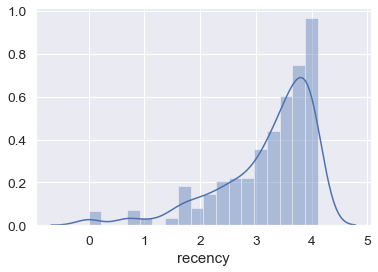

In [75]:
# Recheck
sns.distplot(Log_Tfd_Data['recency'])

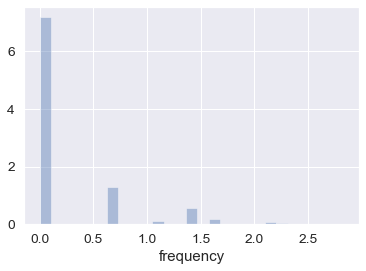

In [76]:
sns.distplot(Log_Tfd_Data['frequency'])

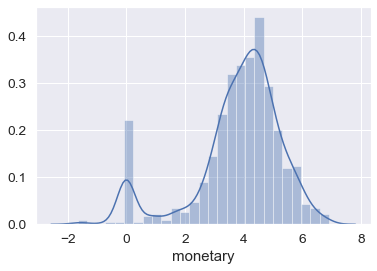

In [77]:
sns.distplot(Log_Tfd_Data['monetary'])

In [78]:
# Normalization by scale
from sklearn.preprocessing import StandardScaler

scaleobj = StandardScaler()
Scaled_Data = scaleobj.fit_transform(Log_Tfd_Data)
# transform to dataframe
Scaled_Data = pd.DataFrame(Scaled_Data, index = df_rfm2.index, columns = Log_Tfd_Data.columns)

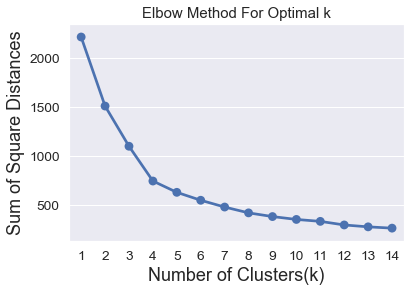

In [79]:
# K-means aglorithm
from sklearn.cluster import KMeans

# Search for optimal K
sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init='k-means++', max_iter=1000)
    km = km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum(square_distance) and sum(num_of_clusters)
ax = sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)', size=18)
plt.ylabel('Sum of Square Distances', size=18)
plt.title('Elbow Method For Optimal k')
ax.figure.savefig(tmp_fig_dir + "elbow-method-searching-optimal-k.jpg")

In [80]:
# Build K-means clustering model
num_clusters = 5  # TODO: tune this
KMean_clust = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=1000)
KMean_clust.fit(Scaled_Data)
df_rfm2['Cluster'] = KMean_clust.labels_
pprint(df_rfm2.Cluster.value_counts())

2    377
4    134
1    118
0     78
3     32
Name: Cluster, dtype: int64


<Figure size 576x576 with 0 Axes>

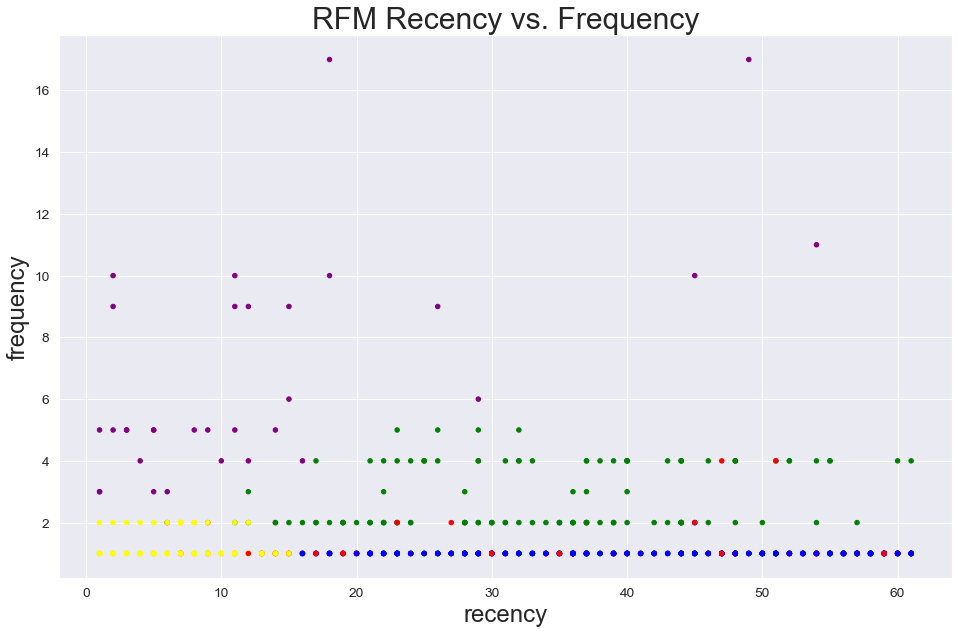

In [81]:
# Scatter Plot Frequency Vs Recency
plt.figure(figsize=(8,8))
Colors = ["red", "green", "blue", 'purple', 'yellow']
df_rfm2['Color'] = df_rfm2['Cluster'].map(lambda p: Colors[p])
ax = df_rfm2.plot(kind="scatter", x="recency", y="frequency", figsize=(16,10), c=df_rfm2['Color'])
ax.set_ylabel('frequency', fontsize=24)
ax.set_xlabel('recency', fontsize=24)
ax.set_title('RFM Recency vs. Frequency', fontsize=30)
ax.get_figure().savefig(tmp_fig_dir + "RFM-Recency-vs-Frequency.jpg")
# plt.show()

<Figure size 576x576 with 0 Axes>

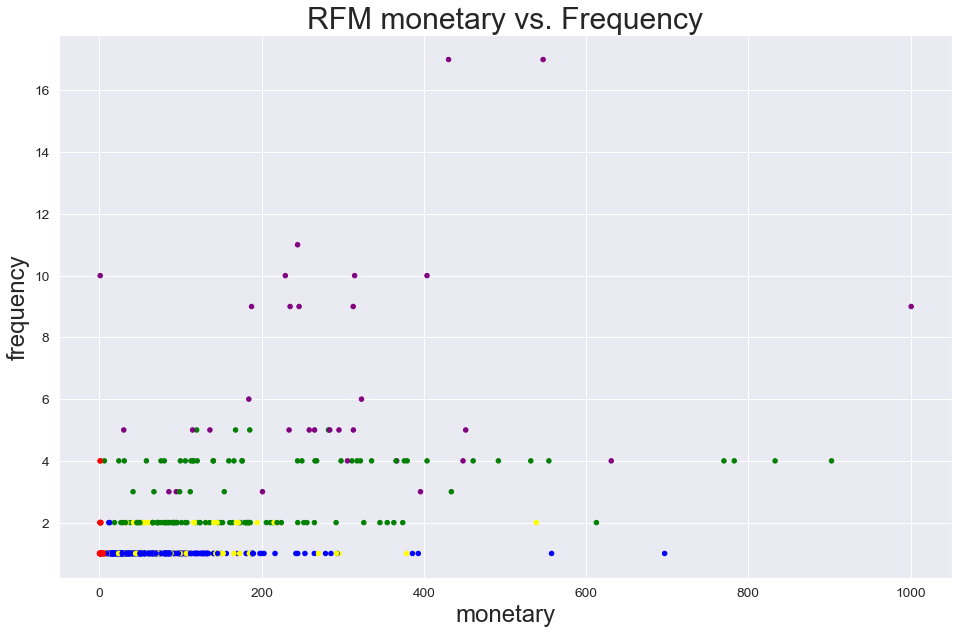

In [82]:
# Scatter Plot Frequency Vs Recency
plt.figure(figsize=(8,8))
Colors = ["red", "green", "blue", 'purple', 'yellow']
df_rfm2['Color'] = df_rfm2['Cluster'].map(lambda p: Colors[p])
ax = df_rfm2.plot(kind="scatter", x="monetary", y="frequency",figsize=(16,10), c=df_rfm2['Color'])
ax.set_ylabel('frequency', fontsize=24)
ax.set_xlabel('monetary', fontsize=24)
ax.set_title('RFM monetary vs. Frequency', fontsize=30)
ax.get_figure().savefig(tmp_fig_dir + "RFM-Monetary-vs-Frequency.jpg")
plt.show()

<Figure size 576x576 with 0 Axes>

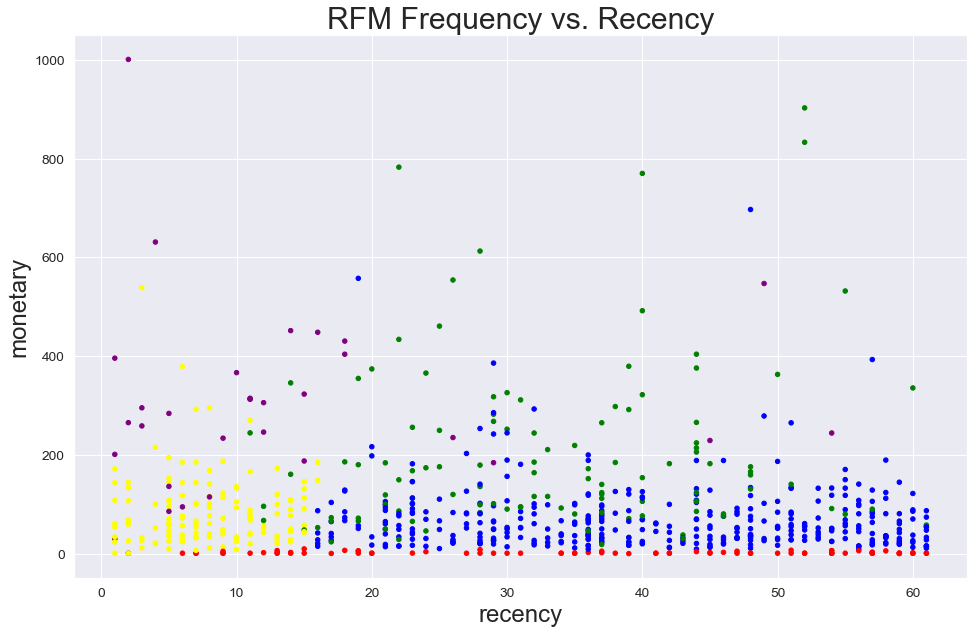

In [83]:
# Scatter Plot Frequency Vs Recency
plt.figure(figsize=(8,8))
Colors = ["red", "green", "blue", 'purple', 'yellow']
df_rfm2['Color'] = df_rfm2['Cluster'].map(lambda p: Colors[p])
ax = df_rfm2.plot(kind="scatter", x="recency", y="monetary",figsize=(16,10),c = df_rfm2['Color'])
ax.set_ylabel('monetary', fontsize=24)
ax.set_xlabel('recency', fontsize=24)
ax.set_title('RFM Frequency vs. Recency', fontsize=30)
ax.get_figure().savefig(tmp_fig_dir + "RFM-Frequency-Vs-Recency.jpg")
plt.show()

### 3.4 Summary of clusters and marketing strategy based on RFM analysis

**<span style="color:green">Cluster 1</span>**

- **At Risk Customers** spent big amounts, but haven’t purchased recently. 

- Send them personalized reactivation campaigns to reconnect, and offer renewals and helpful products to encourage other purchase(s).

**<span style="color:blue">Cluster 2</span>**

- **New Customers** have a high overall recency score but are not frequent shoppers. 
- Start building relationships with these customers by providing onboarding support and special offers to increase their visit(s).

**<span style="color:purple">Cluster 3</span>**

- **Champion Customers** are the best customers, who bought most recently, most often, and are heavy spenders. 

- Reward these customers. They can become early adopters for new products and will help promote the brand.


**<span style="color:yellow">Cluster 4</span>**

- **Require Activation Customers** are poorest performers of our RFM model. They might have went with our competitors for now and will require a different activation strategy to win them back. 

- Bring them back with relevant promotions, and run surveys to find out what went wrong and avoid losing them to a competitor.


**<span style="color:red">Cluster 0</span>**

- **Potential Loyal Customers** with average frequency and who spent a good amount. 

- Offer membership or loyalty programs or recommend related products to upsell them and help them become your Loyalists or Champions.